# Filter-Level Entropy Analysis and Pruning

## Preparation

### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

### Data preparation

In [ ]:
# load MNIST
((trainX, trainY), (testX, testY)) = mnist.load_data()

# edit shapes to make Keras happy
trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

# do a train/validation split with the same random state as the trained model
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, random_state = 0)

# save the integer labels
trainY_int = trainY
validationY_int = validationY
testY_int = testY

# turn labels into one-hot vectors
trainY = to_categorical(trainY, 10)
validationY = to_categorical(validationY, 10)
testY = to_categorical(testY, 10)

## Extract weights from the network

In [ ]:
# load a model
model = load_model('CNN_MNIST_baseline')

In [ ]:
# for each layer, print some stuff
for layer in model.layers:
    # print the name of the layer
    print('Layer name:\t', layer.name)

    # print the output shape of the layer
    print('Layer shape:\t', layer.output.shape)

Layer name:	 rescaling_44
Layer shape:	 (None, 28, 28, 1)
Layer name:	 conv2d_502
Layer shape:	 (None, 26, 26, 16)
Layer name:	 activation_366
Layer shape:	 (None, 26, 26, 16)
Layer name:	 max_pooling2d_502
Layer shape:	 (None, 13, 13, 16)
Layer name:	 flatten_263
Layer shape:	 (None, 2704)
Layer name:	 dense_263
Layer shape:	 (None, 10)
Layer name:	 activation_367
Layer shape:	 (None, 10)


In [ ]:
weights = model.get_weights()

print('Shapes of each weight array:\n')
[print(x.shape) for x in weights]
print('\n')

# weights[0] = weights for the convolutions
# weights[1] = biases for the convolutions
# weights[2] = weights and biases for the dense layer
# weights[3] = biases for the output

# filters are in weights[0]
for filter_number in range(16):
    print('Filter', filter_number, 'has weights:\n')
    print(weights[0][:, :, 0, filter_number], '\n')

#weights[0][:, :, 0, filter_number] *= 0

Shapes of each weight array:

(3, 3, 1, 16)
(16,)
(2704, 10)
(10,)


Filter 0 has weights:

[[0.08399448 0.28148448 1.0837278 ]
 [1.6085213  1.8095822  1.988991  ]
 [1.8953444  1.5176272  1.4485273 ]] 

Filter 1 has weights:

[[-0.59411085  0.38023028  1.2108037 ]
 [ 0.7789616   2.1166997   1.5399355 ]
 [ 1.2572244   1.6138644   0.56757987]] 

Filter 2 has weights:

[[-2.222721  -1.6915365 -3.0677345]
 [-2.570781  -1.1528153 -1.5423218]
 [ 0.9082809  2.1922708  1.06483  ]] 

Filter 3 has weights:

[[-1.0966239   0.1648427   0.7983462 ]
 [ 1.0791886   3.0585845   2.343832  ]
 [-0.34608862  1.3927871   0.9920167 ]] 

Filter 4 has weights:

[[-0.9111253  -0.2632278  -0.02609901]
 [-1.9972112  -1.8719246  -2.412887  ]
 [ 0.5390199  -0.34724462 -1.0287819 ]] 

Filter 5 has weights:

[[-0.14685151 -1.3828248  -1.6562883 ]
 [-0.54765296 -1.2531892  -0.36301008]
 [-1.4888862  -1.5506439   0.05207771]] 

Filter 6 has weights:

[[1.5161341 1.3948911 1.6433269]
 [2.2460861 1.887583  1.4928001]
 [

## Greedy Pruning

In [ ]:
def greedy_pruning_shallow_conv(model_path, validationX, validationY, num_filters):

    print('\n=================================== CNN Accuracy ===================================\n')

    model = load_model(model_path)

    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    print('Validation accuracy of full net:', format(validation_accuracy, '.4f'))

    pruned_accuracies = [validation_accuracy]

    # initialize filter numbers
    filters = [i for i in range(num_filters)]
    removed_filters = []

    for i in range(15):

        print('\n================================ Greedy Iteration', i + 1, '================================')

        # initialize best val accuracy and worst filter
        best_validation_accuracy = 0
        worst_filter = None

        # find the worst filter in a greedy sense
        for filter_number in filters:

            # load full model
            model = load_model(model_path)

            # get the weights
            weights = model.get_weights()

            # set the removed filter and current filter weights and biases to 0
            weights[0][:, :, 0, removed_filters + [filter_number]] *= 0
            weights[1][removed_filters + [filter_number]] *= 0
            model.set_weights(weights)

            # compute validation accuracy after removing the current filter
            validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]

            #print('Removing filter', filter_number, 'gives validation accuracy', format(validation_accuracy, '.4f'))

            # if this val accuracy is the highest we have seen, set the current filter as the "worst"
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                worst_filter = filter_number

        # delete the worst filter
        filters.remove(worst_filter)
        removed_filters.append(worst_filter)

        print('\nRemoving filter:', worst_filter, '\nValidation accuracy:', format(best_validation_accuracy, '.4f'))
        pruned_accuracies.append(best_validation_accuracy)

        #print('\nRemaining filters:', filters)

    # if there are no convolutonal filters, the model will predict the same output everytime
    # (biases to the output layer will control this as everything else is 0)

    pruned_accuracies.append(0.1)

    plt.style.use('ggplot')
    plt.figure()
    plt.plot(pruned_accuracies)
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Number of Pruned Filters')
    plt.title('Validation Accuracy with Greedy Filter Pruning')
    
    return pruned_accuracies, removed_filters


=================================== CNN Accuracy ===================================

Validation accuracy of full net: 0.9731

================================ Greedy Iteration 1 ================================

Removing filter: 3 
Validation accuracy: 0.9733

================================ Greedy Iteration 2 ================================

Removing filter: 4 
Validation accuracy: 0.9705

================================ Greedy Iteration 3 ================================

Removing filter: 5 
Validation accuracy: 0.9615

================================ Greedy Iteration 4 ================================

Removing filter: 10 
Validation accuracy: 0.9467

================================ Greedy Iteration 5 ================================

Removing filter: 11 
Validation accuracy: 0.9195

================================ Greedy Iteration 6 ================================

Removing filter: 7 
Validation accuracy: 0.8872

================================ Greedy Iteration 7 ========

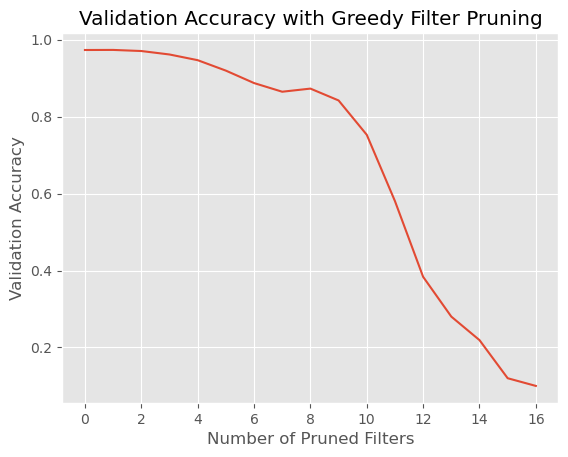

In [ ]:
# run greedy pruning
pruned_accuracies, removed_filters = greedy_pruning_shallow_conv('CNN_MNIST_baseline', validationX, validationY, 16)

print(pruned_accuracies)


=================================== CNN Accuracy ===================================

Validation accuracy of full net: 0.9833

================================ Greedy Iteration 1 ================================

Removing filter: 11 
Validation accuracy: 0.9785

================================ Greedy Iteration 2 ================================

Removing filter: 7 
Validation accuracy: 0.9637

================================ Greedy Iteration 3 ================================

Removing filter: 8 
Validation accuracy: 0.9123

================================ Greedy Iteration 4 ================================

Removing filter: 1 
Validation accuracy: 0.8495

================================ Greedy Iteration 5 ================================

Removing filter: 2 
Validation accuracy: 0.7633

================================ Greedy Iteration 6 ================================

Removing filter: 9 
Validation accuracy: 0.6447

================================ Greedy Iteration 7 =========

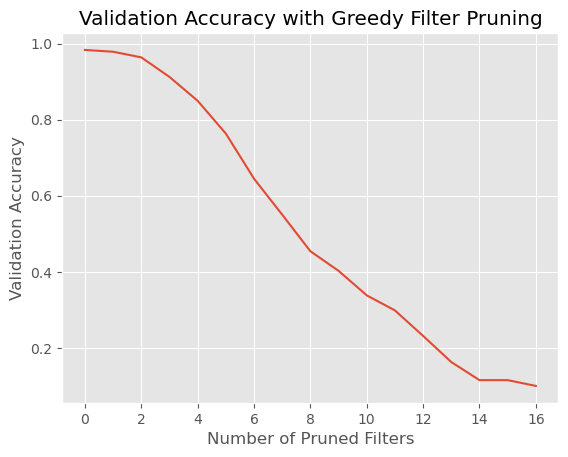

In [ ]:
# this thing gets so mad and spits out many warnings, but they don't seem to harm anything

pruned_accuracies_reg, removed_filters = greedy_pruning_shallow_conv('CNN_MNIST_regularized_baseline', validationX, validationY, 16)

print(pruned_accuracies_reg)

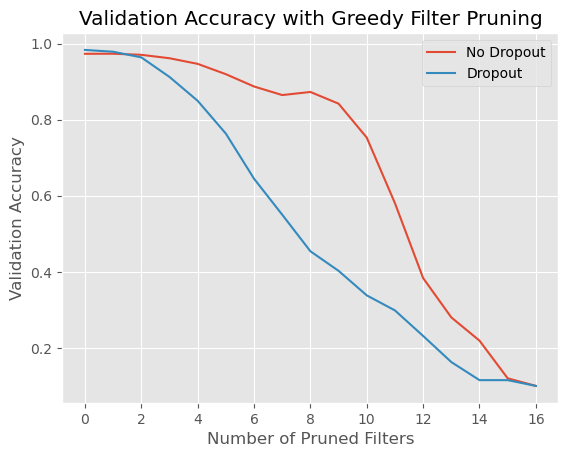

In [ ]:
plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies, label = 'No Dropout')
plt.plot(pruned_accuracies_reg, label = 'Dropout')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Greedy Filter Pruning')

plt.legend()

## Extract layer outputs

In [ ]:
# load a model
model = load_model('CNN_MNIST_baseline')

# Extracts the outputs of all layers
layer_outputs = [layer.output for layer in model.layers] 

# Creates a model that will return these outputs, given the model input
activation_model = model.Model(inputs = model.input, outputs = layer_outputs)

# returns a list of Numpy arrays: 4one array per layer activation
#activations = activation_model.predict(trainX[trainY == 0])
activations = activation_model.predict(trainX)

AttributeError: 'Sequential' object has no attribute 'Model'

In [ ]:
# check the layer names and data representation shapes
for layer, activation in zip(model.layers, activations):
    print(layer)
    print(activation.shape)

NameError: name 'activations' is not defined

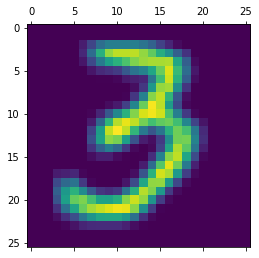

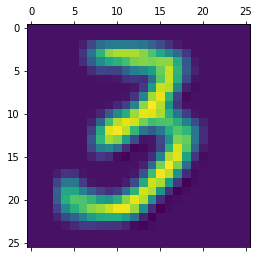

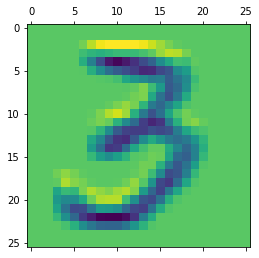

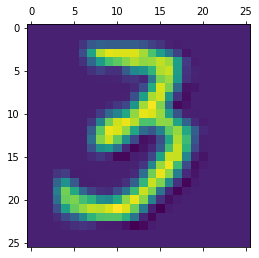

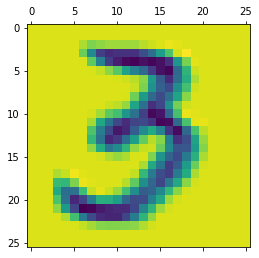

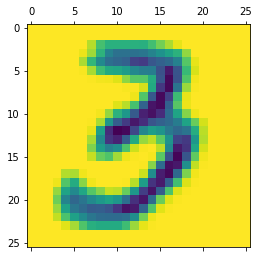

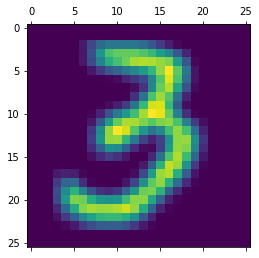

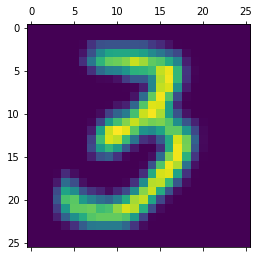

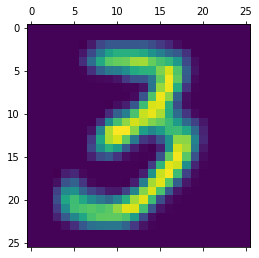

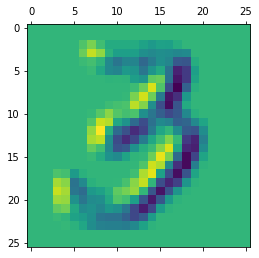

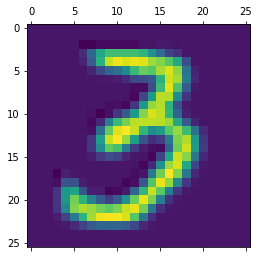

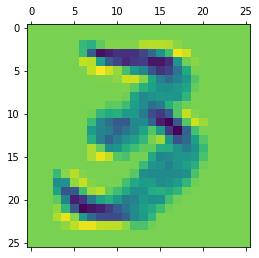

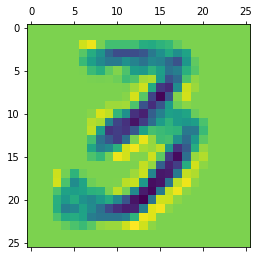

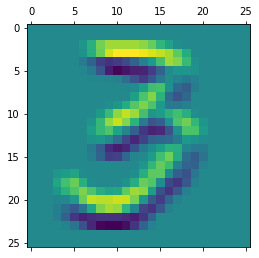

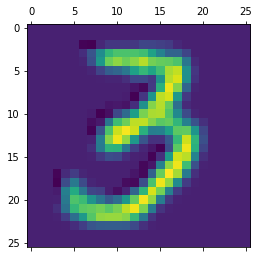

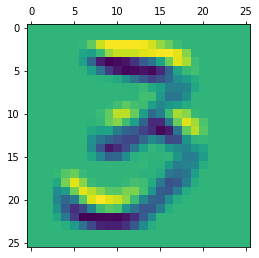

In [ ]:
l = 1
img = 0

activation = activations[l]

for j in range(activation.shape[-1]):
    plt.matshow(activation[img, :, :, j])

In [ ]:
l = -1
img = 0

activation = activations[l]

activation.mean(axis = 0)

array([0.10089353, 0.10846104, 0.10536999, 0.10169567, 0.09825314,
       0.08931642, 0.09643674, 0.10228993, 0.10210565, 0.09514087],
      dtype=float32)

## Entropies for Convolutional Feature Maps

In [ ]:
from scipy.special import entr

train_activations = activation_model.predict(trainX)
test_activations = activation_model.predict(testX)

predicted_trainY = model.predict(trainX).argmax(axis = 1)
predicted_testY = model.predict(testX).argmax(axis = 1)

layer = 2

train_activation = train_activations[layer]
test_activation = test_activations[layer]

313/313 [==============================] - 0s 1ms/step


### Filter entropies for train vs test set and correct vs incorrect classifications

Let's find filter-level entropies for training data with correct/incorrect predictions and the same for the test set

In [ ]:
good_train_predictions = predicted_trainY == trainY.argmax(axis = 1)
bad_train_predictions = predicted_trainY != trainY.argmax(axis = 1)

good_train_activation = train_activation[good_train_predictions]
bad_train_activation = train_activation[bad_train_predictions]

good_test_predictions = predicted_testY == testY.argmax(axis = 1)
bad_test_predictions = predicted_testY != testY.argmax(axis = 1)

good_test_activation = test_activation[good_test_predictions]
bad_test_activation = test_activation[bad_test_predictions]

from scipy.special import entr

good_train_entropy_list = []
bad_train_entropy_list = []
good_test_entropy_list = []
bad_test_entropy_list = []

for j in range(good_train_activation.shape[-1]):
    good_train_filter_activation = np.array(good_train_activation[:, :, :, j])
    good_train_filter_entropy = entr(good_train_filter_activation).sum(axis = 0).mean()
    good_train_entropy_list.append(good_train_filter_entropy)
    
for j in range(bad_train_activation.shape[-1]):
    bad_train_filter_activation = np.array(bad_train_activation[:, :, :, j])
    bad_train_filter_entropy = entr(bad_train_filter_activation).sum(axis = 0).mean()
    bad_train_entropy_list.append(bad_train_filter_entropy)
    
for j in range(good_test_activation.shape[-1]):
    good_test_filter_activation = np.array(good_test_activation[:, :, :, j])
    good_test_filter_entropy = entr(good_test_filter_activation).sum(axis = 0).mean()
    good_test_entropy_list.append(good_test_filter_entropy)

for j in range(bad_test_activation.shape[-1]):
    bad_test_filter_activation = np.array(bad_test_activation[:, :, :, j])
    bad_test_filter_entropy = entr(bad_test_filter_activation).sum(axis = 0).mean()
    bad_test_entropy_list.append(bad_test_filter_entropy)

(0.0, 16000.0)

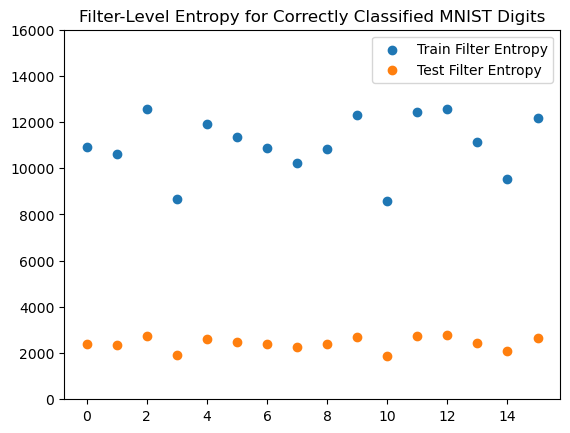

In [ ]:
plt.scatter(range(16), good_train_entropy_list, label = 'Train Filter Entropy')
plt.scatter(range(16), good_test_entropy_list, label = 'Test Filter Entropy')
plt.legend()
plt.title('Filter-Level Entropy for Correctly Classified MNIST Digits')
plt.ylim(0,16000)

(0.0, 260.0)

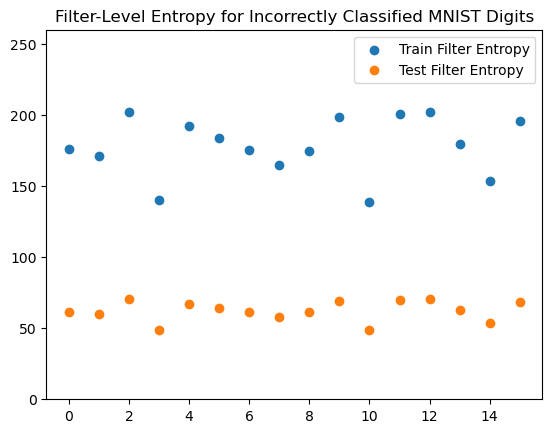

In [ ]:
plt.scatter(range(16), bad_train_entropy_list, label = 'Train Filter Entropy')
plt.scatter(range(16), bad_test_entropy_list, label = 'Test Filter Entropy')
plt.legend()
plt.title('Filter-Level Entropy for Incorrectly Classified MNIST Digits')
plt.ylim(0,260)

It seems the same entropy patterns hold across correctly and incorrectly classified MNIST characters.

In [ ]:
good_train_predictions = predictedY_int == validationY_int
bad_train_predictions = predictedY_int == validationY_int
    
sum(good_train_predictions)

NameError: name 'predictedY_int' is not defined

## Effects of Pruning Individual Filters

In [ ]:
from sklearn.metrics import confusion_matrix

############################## prune filters individually ##############################
print('Computing pruned metrics')

validation_accuracies = []

class_accuracies = []

class_mses = []
mean_mses = []

correct_mses = []
incorrect_mses = []

mean_correct_mses = []
mean_incorrect_mses = []

predicted_dist_entropy_means = []
correct_predicted_dist_entropy_means = []
incorrect_predicted_dist_entropy_means = []

validationY_int = validationY.argmax(axis = 1)

for i in range(16):
    
    print('Pruning filter', i)
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, i] *= 0
    weights[1][i] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    validation_accuracies.append(validation_accuracy)
    
    # compute class-level accuracies
    predictedY = model.predict(validationX)
    predictedY_int = predictedY.argmax(axis = 1)
    
    confusion_mat = confusion_matrix(validationY_int, predictedY_int)
    class_accuracies_prune = confusion_mat.diagonal()/confusion_mat.sum(axis = 1)
    
    class_accuracies.append(class_accuracies_prune)
    
    # compute class-level MSEs
    class_mses_prune = np.linalg.norm(predictedY - validationY, axis = 0) ** 2 / validationY.shape[0]
    class_mses.append(class_mses_prune)
    
    mean_mses.append(class_mses_prune.mean())
    
    # compute class-level MSEs of correct and incorrect predictions separately
    good_val_predictions = predictedY_int == validationY_int
    bad_val_predictions = predictedY_int != validationY_int
    
    correct_mses_prune = np.linalg.norm((predictedY - validationY)[good_val_predictions], axis = 0) ** 2 / sum(good_val_predictions)
    correct_mses.append(correct_mses_prune)
    
    mean_correct_mses.append(correct_mses_prune.mean())
    
    incorrect_mses_prune = np.linalg.norm((predictedY - validationY)[bad_val_predictions], axis = 0) ** 2 / sum(bad_val_predictions)
    incorrect_mses.append(incorrect_mses_prune)
    
    mean_incorrect_mses.append(incorrect_mses_prune.mean())
    
    # compute predicted Y mean entropy for all, correct, and incorrect predictions
    predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY]).mean())
    correct_predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY[good_val_predictions]]).mean())
    incorrect_predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY[bad_val_predictions]]).mean())
    
############################## compute filter-level entropies ##############################
print('Computing filter-level entropies')

# load the model
model = load_model('CNN_MNIST_baseline')

# extract the activations for the specified layer
layer = 2
activation = activations[layer]

# initilize a list of entropies
entropy_list = []

# loop over the filters to build a list of [filter number, entropy]
for j in range(activation.shape[-1]):
    # extract activations for the jth filter
    filter_activation = np.array(activation[:, :, :, j])
    
    # find the entropy of the activations of the filter
    filter_entropy = entr(filter_activation).sum(axis = 0).mean()
    
    # add [filter number, entropy] to the list
    entropy_list.append(filter_entropy)

Computing pruned metrics
Pruning filter 0


2023-04-21 21:07:43.000681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 21:07:43.000998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 21:07:43.001293: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-21 21:07:43.001356: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-21 21:07:43.001411: W tensorflow/compiler/xl

469/469 [==============================] - 1s 1ms/step
Pruning filter 1
469/469 [==============================] - 1s 1ms/step
Pruning filter 2
469/469 [==============================] - 1s 1ms/step
Pruning filter 3
469/469 [==============================] - 1s 1ms/step
Pruning filter 4
469/469 [==============================] - 1s 1ms/step
Pruning filter 5
469/469 [==============================] - 1s 1ms/step
Pruning filter 6
469/469 [==============================] - 1s 1ms/step
Pruning filter 7
469/469 [==============================] - 1s 1ms/step
Pruning filter 8
469/469 [==============================] - 1s 1ms/step
Pruning filter 9
469/469 [==============================] - 1s 1ms/step
Pruning filter 10
469/469 [==============================] - 1s 1ms/step
Pruning filter 11
469/469 [==============================] - 1s 1ms/step
Pruning filter 12
469/469 [==============================] - 1s 1ms/step
Pruning filter 13
469/469 [==============================] - 1s 1ms/step
Pruni

NameError: name 'activations' is not defined

In [ ]:
import pandas as pd

df = pd.DataFrame(zip(entropy_list, validation_accuracies, mean_mses, mean_correct_mses, mean_incorrect_mses, predicted_dist_entropy_means,
                      correct_predicted_dist_entropy_means, incorrect_predicted_dist_entropy_means),
                  columns = ['Filter Entropy', 'Val accuracy', 'MSE', 'Correct MSE', 'Incorrect MSE', 'Output Entropy', 'Correct Output Entropy', 'Incorrect Output Entropy'])

df = pd.concat([df, pd.DataFrame(class_accuracies, columns = ['0 acc', '1 acc', '2 acc', '3 acc', '4 acc', '5 acc', '6 acc', '7 acc', '8 acc', '9 acc'])], axis = 1)

df = pd.concat([df, pd.DataFrame(class_mses, columns = ['0 MSE', '1 MSE', '2 MSE', '3 MSE', '4 MSE', '5 MSE', '6 MSE', '7 MSE', '8 MSE', '9 MSE'])], axis = 1)

df = pd.concat([df, pd.DataFrame(correct_mses, columns = ['0 correct MSE', '1 correct MSE', '2 correct MSE', '3 correct MSE', '4 correct MSE',
                                                          '5 correct MSE', '6 correct MSE', '7 correct MSE', '8 correct MSE', '9 correct MSE'])], axis = 1)

df = pd.concat([df, pd.DataFrame(incorrect_mses, columns = ['0 incorrect MSE', '1 incorrect MSE', '2 incorrect MSE', '3 incorrect MSE', '4 incorrect MSE',
                                                            '5 incorrect MSE', '6 incorrect MSE', '7 incorrect MSE', '8 incorrect MSE', '9 incorrect MSE'])], axis = 1)


df

#df.to_csv('Single_Filter_Prune_Metrics.csv')

Filter Entropy  Val accuracy       MSE  Correct MSE  Incorrect MSE  \
0     11079.274414      0.969667  0.004658     0.001075       0.119178   
1     10771.479492      0.971400  0.004394     0.000990       0.120005   
2     12758.914062      0.959800  0.006339     0.001475       0.122454   
3      8806.171875      0.973333  0.004333     0.001012       0.125543   
4     12107.949219      0.972200  0.004204     0.000899       0.119783   
5     11552.464844      0.972067  0.004463     0.001035       0.123737   
6     11047.671875      0.970267  0.004539     0.001027       0.119151   
7     10386.335938      0.970067  0.004588     0.000991       0.121165   
8     11004.882812      0.968333  0.004762     0.001027       0.118979   
9     12483.358398      0.895867  0.015838     0.002099       0.134035   
10     8719.502930      0.972533  0.004208     0.000864       0.122611   
11    12657.209961      0.957867  0.006368     0.001359       0.120244   
12    12776.925781      0.950933  0.007694     0.001752       0.122855   
13    11325.502930      0.952533  0.007459     0.001859       0.119838   
14     9683.320312      0.972933  0.004230     0.000938       0.122577   
15    12360.447266      0.838200  0.023154     0.004406       0.120281   

    Output Entropy  Correct Output Entropy  Incorrect Output Entropy  \
0         0.117758                0.098284                  0.740267   
1         0.110008                0.091784                  0.728988   
2         0.146989                0.121877                  0.746564   
3         0.105086                0.088624                  0.705964   
4         0.097391                0.079454                  0.724696   
5         0.106344                0.089149                  0.704720   
6         0.113426                0.094459                  0.732358   
7         0.109012                0.090168                  0.719715   
8         0.113736                0.093584                  0.729955   
9         0.180246                0.131084                  0.603188   
10        0.096095                0.078846                  0.706827   
11        0.135218                0.109025                  0.730690   
12        0.165287                0.136128                  0.730404   
13        0.173271                0.142900                  0.782737   
14        0.099032                0.082248                  0.702360   
15        0.344762                0.248229                  0.844851   

       0 acc     1 acc  ...  0 incorrect MSE  1 incorrect MSE  \
0   0.985430  0.987847  ...         0.077400         0.057421   
1   0.986093  0.989583  ...         0.078956         0.054387   
2   0.983444  0.944444  ...         0.050700         0.114334   
3   0.983444  0.988426  ...         0.074866         0.059333   
4   0.994040  0.984954  ...         0.084509         0.058702   
5   0.994702  0.984375  ...         0.096568         0.061323   
6   0.986755  0.989005  ...         0.081220         0.063522   
7   0.985430  0.986690  ...         0.076410         0.066527   
8   0.986093  0.989005  ...         0.080501         0.060854   
9   0.999338  0.972222  ...         0.064168         0.033216   
10  0.983444  0.987269  ...         0.069748         0.062418   
11  0.990728  0.939236  ...         0.047325         0.114397   
12  0.981457  0.960648  ...         0.046097         0.067633   
13  0.984106  0.946181  ...         0.048911         0.092237   
14  0.985430  0.987269  ...         0.075529         0.064196   
15  0.893377  0.488426  ...         0.046193         0.272242   

    2 incorrect MSE  3 incorrect MSE  4 incorrect MSE  5 incorrect MSE  \
0          0.231439         0.109571         0.110362         0.103151   
1          0.231642         0.109596         0.119232         0.110936   
2          0.204438         0.164460         0.104324         0.126398   
3          0.239961         0.112191         0.121534         0.119815   
4          0.190329         0.114478        

In [ ]:
from sklearn.metrics import confusion_matrix

############################## prune filters in pairs ##############################
print('Computing pruned metrics')

validation_accuracies = []

class_accuracies = []

class_mses = []
mean_mses = []

correct_mses = []
incorrect_mses = []

mean_correct_mses = []
mean_incorrect_mses = []

predicted_dist_entropy_means = []
correct_predicted_dist_entropy_means = []
incorrect_predicted_dist_entropy_means = []

validationY_int = validationY.argmax(axis = 1)

for i in range(16):
    for j in range(i + 1, 16):
    
        print('Pruning filters', i, 'and', j)

        # load full model
        model = load_model('CNN_MNIST_baseline')

        # get the weights
        weights = model.get_weights()

        # set the removed filter and current filter weights and biases to 0
        weights[0][:, :, 0, [i, j]] *= 0
        weights[1][[i, j]] *= 0
        model.set_weights(weights)

        # compute validation accuracy after removing the current filter
        validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
        validation_accuracies.append(validation_accuracy)

        # compute class-level accuracies
        predictedY = model.predict(validationX)
        predictedY_int = predictedY.argmax(axis = 1)

        confusion_mat = confusion_matrix(validationY_int, predictedY_int)
        class_accuracies_prune = confusion_mat.diagonal()/confusion_mat.sum(axis = 1)

        class_accuracies.append(class_accuracies_prune)

        # compute class-level MSEs
        class_mses_prune = np.linalg.norm(predictedY - validationY, axis = 0) ** 2 / validationY.shape[0]
        class_mses.append(class_mses_prune)

        mean_mses.append(class_mses_prune.mean())

        # compute class-level MSEs of correct and incorrect predictions separately
        good_val_predictions = predictedY_int == validationY_int
        bad_val_predictions = predictedY_int != validationY_int

        correct_mses_prune = np.linalg.norm((predictedY - validationY)[good_val_predictions], axis = 0) ** 2 / sum(good_val_predictions)
        correct_mses.append(correct_mses_prune)

        mean_correct_mses.append(correct_mses_prune.mean())

        incorrect_mses_prune = np.linalg.norm((predictedY - validationY)[bad_val_predictions], axis = 0) ** 2 / sum(bad_val_predictions)
        incorrect_mses.append(incorrect_mses_prune)

        mean_incorrect_mses.append(incorrect_mses_prune.mean())

        # compute predicted Y mean entropy for all, correct, and incorrect predictions
        predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY]).mean())
        correct_predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY[good_val_predictions]]).mean())
        incorrect_predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY[bad_val_predictions]]).mean())

Computing pruned metrics
Pruning filters 0 and 1
Pruning filters 0 and 2
Pruning filters 0 and 3
Pruning filters 0 and 4
Pruning filters 0 and 5
Pruning filters 0 and 6
Pruning filters 0 and 7
Pruning filters 0 and 8
Pruning filters 0 and 9
Pruning filters 0 and 10
Pruning filters 0 and 11
Pruning filters 0 and 12
Pruning filters 0 and 13
Pruning filters 0 and 14
Pruning filters 0 and 15
Pruning filters 1 and 2
Pruning filters 1 and 3
Pruning filters 1 and 4
Pruning filters 1 and 5
Pruning filters 1 and 6
Pruning filters 1 and 7
Pruning filters 1 and 8
Pruning filters 1 and 9
Pruning filters 1 and 10
Pruning filters 1 and 11
Pruning filters 1 and 12
Pruning filters 1 and 13
Pruning filters 1 and 14
Pruning filters 1 and 15
Pruning filters 2 and 3
Pruning filters 2 and 4
Pruning filters 2 and 5
Pruning filters 2 and 6
Pruning filters 2 and 7
Pruning filters 2 and 8
Pruning filters 2 and 9
Pruning filters 2 and 10
Pruning filters 2 and 11
Pruning filters 2 and 12
Pruning filters 2 and 13

In [ ]:
############################## compute filter-level entropies ##############################

print('Computing filter-level entropies')

# load the model
model = load_model('CNN_MNIST_baseline')

# extract the activations for the specified layer
layer = 2
activation = activations[layer]

# initilize a list of entropies
entropy_list = []

# loop over the filters to build a list of [filter number, entropy]
for j in range(activation.shape[-1]):
    # extract activations for the jth filter
    filter_activation = np.array(activation[:, :, :, j])
    
    # find the entropy of the activations of the filter
    filter_entropy = entr(filter_activation).sum(axis = 0).mean()
    
    # add [filter number, entropy] to the list
    entropy_list.append(filter_entropy)
    
# initilize a list of entropies
filter_number_1 = []
filter_number_2 = []
entropy_list_1 = []
entropy_list_2 = []

for i in range(16):
    for j in range(i + 1, 16):
        entropy_list_1.append(entropy_list[i])
        entropy_list_2.append(entropy_list[j])
        filter_number_1.append(i)
        filter_number_2.append(j)

Computing filter-level entropies


In [ ]:
import pandas as pd

df = pd.DataFrame(zip(filter_number_1, filter_number_2, entropy_list_1, entropy_list_2, validation_accuracies, mean_mses, mean_correct_mses, mean_incorrect_mses,
                      predicted_dist_entropy_means, correct_predicted_dist_entropy_means, incorrect_predicted_dist_entropy_means),
                  columns = ['Filter 1', 'Filter 2', 'Filter 1 Entropy', 'Filter 2 Entropy', 'Val accuracy', 'MSE', 'Correct MSE',
                             'Incorrect MSE', 'Output Entropy', 'Correct Output Entropy', 'Incorrect Output Entropy'])

df = pd.concat([df, pd.DataFrame(class_accuracies, columns = ['0 acc', '1 acc', '2 acc', '3 acc', '4 acc', '5 acc', '6 acc', '7 acc', '8 acc', '9 acc'])], axis = 1)

df = pd.concat([df, pd.DataFrame(class_mses, columns = ['0 MSE', '1 MSE', '2 MSE', '3 MSE', '4 MSE', '5 MSE', '6 MSE', '7 MSE', '8 MSE', '9 MSE'])], axis = 1)

df = pd.concat([df, pd.DataFrame(correct_mses, columns = ['0 correct MSE', '1 correct MSE', '2 correct MSE', '3 correct MSE', '4 correct MSE',
                                                          '5 correct MSE', '6 correct MSE', '7 correct MSE', '8 correct MSE', '9 correct MSE'])], axis = 1)

df = pd.concat([df, pd.DataFrame(incorrect_mses, columns = ['0 incorrect MSE', '1 incorrect MSE', '2 incorrect MSE', '3 incorrect MSE', '4 incorrect MSE',
                                                            '5 incorrect MSE', '6 incorrect MSE', '7 incorrect MSE', '8 incorrect MSE', '9 incorrect MSE'])], axis = 1)


df

df.to_csv('Double_Filter_Prune_Metrics.csv')

In [ ]:
df

Filter 1  Filter 2  Filter 1 Entropy  Filter 2 Entropy  Val accuracy  \
0           0         1      11079.275391      10771.479492      0.950333   
1           0         2      11079.275391      12758.914062      0.935000   
2           0         3      11079.275391       8806.171875      0.956067   
3           0         4      11079.275391      12107.949219      0.968533   
4           0         5      11079.275391      11552.464844      0.965067   
..        ...       ...               ...               ...           ...   
115        12        14      12776.925781       9683.320312      0.943600   
116        12        15      12776.925781      12360.447266      0.723800   
117        13        14      11325.502930       9683.320312      0.934200   
118        13        15      11325.502930      12360.447266      0.631533   
119        14        15       9683.320312      12360.447266      0.810200   

          MSE  Correct MSE  Incorrect MSE  Output Entropy  \
0    0.007785     0.001945       0.119522        0.178496   
1    0.009878     0.002434       0.116955        0.220575   
2    0.006974     0.001724       0.121210        0.163375   
3    0.005003     0.001176       0.122799        0.127024   
4    0.005618     0.001369       0.122976        0.142041   
..        ...          ...            ...             ...   
115  0.008673     0.002071       0.119132        0.187422   
116  0.039543     0.006290       0.126683        0.430593   
117  0.010049     0.002403       0.118602        0.213590   
118  0.052353     0.005540       0.132589        0.462182   
119  0.027227     0.005867       0.118406        0.402450   

     Correct Output Entropy  ...  0 incorrect MSE  1 incorrect MSE  \
0                  0.149385  ...         0.057716         0.046126   
1                  0.181802  ...         0.044023         0.059848   
2                  0.137845  ...         0.074011         0.047862   
3                  0.106904  ...         0.077562         0.059725   
4                  0.120515  ...         0.078522         0.056214   
..                      ...  ...              ...              ...   
115                0.153827  ...         0.045990         0.044899   
116                0.313219  ...         0.082262         0.202871   
117                0.171813  ...         0.044018         0.052139   
118                0.270848  ...         0.079526         0.242253   
119                0.301160  ...         0.074951         0.188656   

     2 incorrect MSE  3 incorrect MSE  4 incorrect MSE  5 incorrect MSE  \
0           0.290745         0.091603         0.092678         0.089506   
1           0.221448         0.164475         0.078250         0.107711   
2           0.291667         0.094998         0.094613         0.102132   
3           0.213000         0.111137         0.109393         0.125194   
4           0.235527         0.105265         0.106880         0.105530   
..               ...              ...              ...              ...   
115         0.248572         0.127223         0.077748         0.115185   
116         0.345908         0.123633         0.044811         0.051433   
117         0.220865         0.090761         0.112940         0.138287   
118         0.214623         0.183668         0.087175         0.106704   
119         0.184675         0.113340         0.077255         0.110939   

     6 incorrect MSE  7 incorrect MSE  8 incorrect MSE  9 incorrect MSE  
0           0.067613         0.096222         0.188774         0.174232  
1           0.091795         0.092249         0.193111         0.116646  
2           0.064967         0.109017         0.159324         0.173508  
3           0.100110         0.121975         0.140888         0.169003  
4           0.086318         0.127139         0.151218         0.177147  
..               ...              ...              ...              ...  
115         0.071815         0.129791         0.119159         0.210936  
116         0

## Entropy-based Pruning

In [ ]:
from scipy.special import entr

# extract the activations for the specified layer
layer = 2
activation = activations[layer]

# initilize a list of entropies
entropy_list = []

# loop over the filters to build a list of [filter number, entropy]
for j in range(activation.shape[-1]):
    # extract activations for the jth filter
    filter_activation = np.array(activation[:, :, :, j])
    
    # find the entropy of the activations of the filter
    filter_entropy = entr(filter_activation).sum(axis = 0).mean()
    
    # add [filter number, entropy] to the list
    entropy_list.append([j, filter_entropy])
    
# sort the [filter number, entropy] ascending by entropy
sorted_entropy_list = sorted(entropy_list, key = lambda x: x[1])

# extract the indices sorted in ascending order by entropy
sorted_entropy_indices = [x[0] for x in sorted_entropy_list]

pruned_accuracies_entropy_ascending = []


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [10]
Validation accuracy: 0.9725333452224731

Removed filters: [10, 3]
Validation accuracy: 0.9660666584968567

Removed filters: [10, 3, 14]
Validation accuracy: 0.9419999718666077

Removed filters: [10, 3, 14, 7]
Validation accuracy: 0.8733333349227905

Removed filters: [10, 3, 14, 7, 1]
Validation accuracy: 0.7531333565711975

Removed filters: [10, 3, 14, 7, 1, 8]
Validation accuracy: 0.6092000007629395

Removed filters: [10, 3, 14, 7, 1, 8, 6]
Validation accuracy: 0.507266640663147

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0]
Validation accuracy: 0.41819998621940613

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0, 13]
Validation accuracy: 0.3383333384990692

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0, 13, 5]
Validation accuracy: 0.3131999969482422

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0, 13, 5, 4]
Validation accuracy: 0.3057999908924103

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0, 13, 5, 4, 15]
Validation

Text(0.5, 1.0, 'Validation Accuracy with Entropy-based (Ascending) Greedy Filter Pruning')

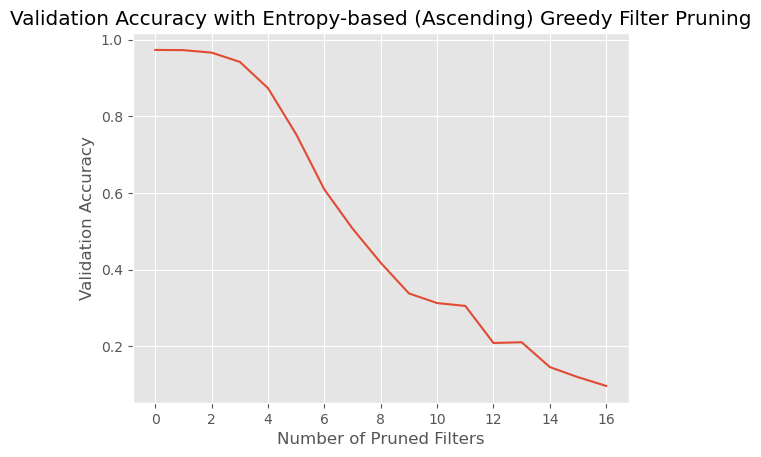

In [ ]:
# prune filters from lowest entropy to highest

pruned_accuracies_entropy_ascending = []

for i in range(17):
    # find the filter numbers of i filters with lowest entropy
    removed_filters = sorted_entropy_indices[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_entropy_ascending.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_entropy_ascending)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Entropy-based (Ascending) Greedy Filter Pruning')


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [12]
Validation accuracy: 0.9509333372116089

Removed filters: [2, 12]
Validation accuracy: 0.8937333226203918

Removed filters: [11, 2, 12]
Validation accuracy: 0.8694666624069214

Removed filters: [9, 11, 2, 12]
Validation accuracy: 0.8205999732017517

Removed filters: [15, 9, 11, 2, 12]
Validation accuracy: 0.5212000012397766

Removed filters: [4, 15, 9, 11, 2, 12]
Validation accuracy: 0.49533334374427795

Removed filters: [5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.4573333263397217

Removed filters: [13, 5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.3505333364009857

Removed filters: [0, 13, 5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.2718000113964081

Removed filters: [6, 0, 13, 5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.20106667280197144

Removed filters: [8, 6, 0, 13, 5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.1451999992132187

Removed filters: [1, 8, 6, 0, 13, 5, 4, 15, 9, 11, 2, 12]


Text(0.5, 1.0, 'Validation Accuracy with Entropy-based (Descending) Greedy Filter Pruning')

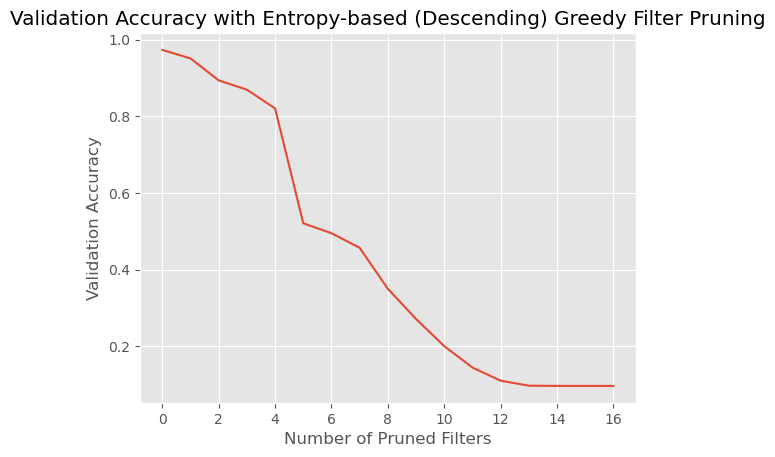

In [ ]:
# prune filters from highest entropy to lowest

pruned_accuracies_entropy_descending = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = sorted_entropy_indices[16-i:]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_entropy_descending.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_entropy_descending)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Entropy-based (Descending) Greedy Filter Pruning')

### Pruning mid-range entropies first (this is not interesting)


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [13]
Validation accuracy: 0.9525333046913147

Removed filters: [13, 0]
Validation accuracy: 0.9069333076477051

Removed filters: [13, 0, 5]
Validation accuracy: 0.885533332824707

Removed filters: [13, 0, 5, 6]
Validation accuracy: 0.7603333592414856

Removed filters: [13, 0, 5, 6, 4]
Validation accuracy: 0.7562666535377502

Removed filters: [13, 0, 5, 6, 4, 8]
Validation accuracy: 0.6240000128746033

Removed filters: [13, 0, 5, 6, 4, 8, 15]
Validation accuracy: 0.281333327293396

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1]
Validation accuracy: 0.2707333266735077

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1, 9]
Validation accuracy: 0.30686667561531067

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1, 9, 7]
Validation accuracy: 0.25546666979789734

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1, 9, 7, 11]
Validation accuracy: 0.17393332719802856

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1, 9, 7, 11, 14]
Validation accu

Text(0.5, 1.0, 'Validation Accuracy with Mid-Entropy Filter Pruning')

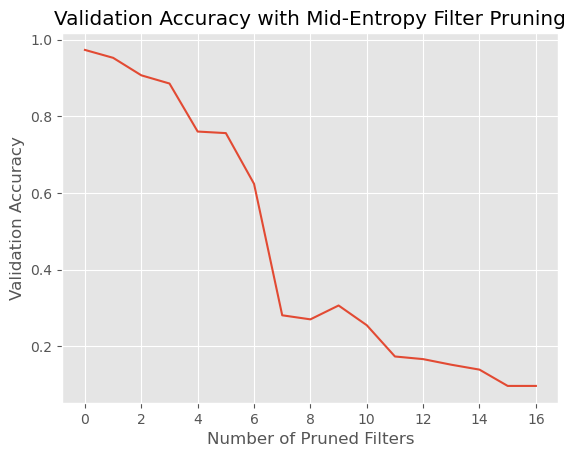

In [ ]:
middle_entropies = [13, 0, 5, 6, 4, 8, 15, 1, 9, 7, 11, 14, 2, 10, 12]

# prune mid-entropy filters
pruned_accuracies_entropy_mid = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = middle_entropies[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_entropy_mid.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_entropy_mid)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Mid-Entropy Filter Pruning')

### Plots for Entropy-Based Pruning

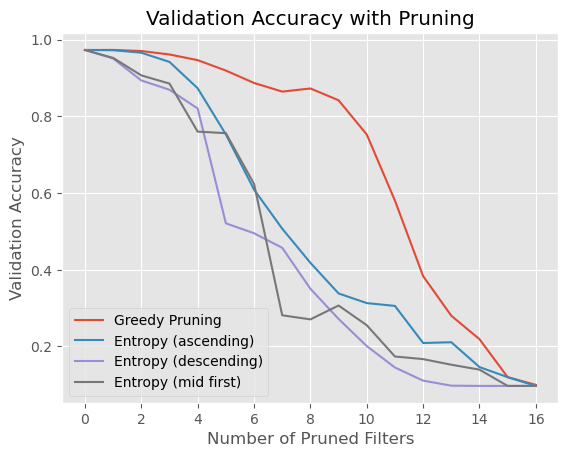

In [ ]:
# Comparing to the brute-force greedy pruning is not really fair... DO NOT USE?

plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies, label = 'Greedy Pruning')
#plt.plot(pruned_accuracies_reg, label = 'Dropout')
plt.plot(pruned_accuracies_entropy_ascending, label = 'Entropy (ascending)')
plt.plot(pruned_accuracies_entropy_descending, label = 'Entropy (descending)')
plt.plot(pruned_accuracies_entropy_mid, label = 'Entropy (mid first)')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Pruning')

plt.legend()

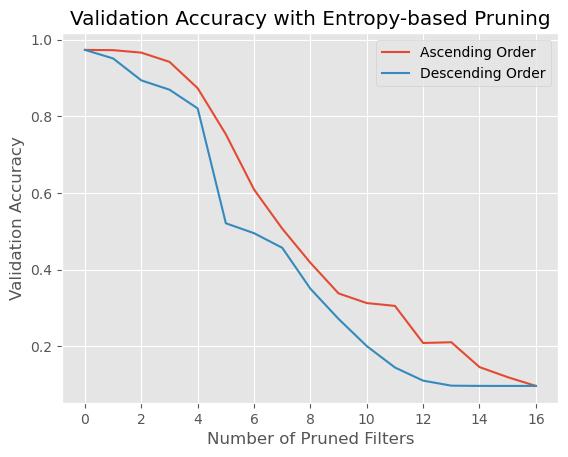

In [ ]:
# GOOD EXAMPLE HERE -- REMOVING HIGH-ENTROPY FILTERS REDUCES ACCURACY MUCH FASTER
# THAN REMOVING LOW-ENTROPY FILTERS

plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies_entropy_ascending, label = 'Ascending Order')
plt.plot(pruned_accuracies_entropy_descending, label = 'Descending Order')
#plt.plot(pruned_accuracies_entropy_mid, label = 'Middle-out Order')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Entropy-based Pruning')

plt.legend()

## MI-based Pruning

In [ ]:
import pickle as pkl
file = 'MI_matrices.pkl'
MI_matrices = pkl.load(open(file, 'rb'))

means = []

for k in range(16):
    for l in range(k):
        MI_matrix = MI_matrices[k+l]
        mean_MI = MI_matrix.mean(axis=0).reshape([26, 26])
        means.append([k, l, np.mean(mean_MI)])
        
means = np.array(means)

In [ ]:
#means[means[:, -1].argsort()][::-1]
MMMIs = np.zeros([16,2])

for k in range(16):
    MMMIs[k,0] = k
    for r in means:
        if k in r: MMMIs[k,1] += r[-1]
            
sorted_MMMIs = MMMIs[MMMIs[:, -1].argsort()]

sorted_MMMIs

array([[15.        ,  1.75847038],
       [13.        ,  1.77653241],
       [14.        ,  1.77763557],
       [12.        ,  1.79129674],
       [10.        ,  1.80656564],
       [11.        ,  1.81169735],
       [ 8.        ,  1.81546636],
       [ 9.        ,  1.81825458],
       [ 1.        ,  1.83294349],
       [ 3.        ,  1.83422645],
       [ 0.        ,  1.83704646],
       [ 7.        ,  1.83804175],
       [ 2.        ,  1.84049638],
       [ 6.        ,  1.84525981],
       [ 4.        ,  1.84830462],
       [ 5.        ,  1.84999787]])


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [15]
Validation accuracy: 0.8381999731063843

Removed filters: [15, 13]
Validation accuracy: 0.631600022315979

Removed filters: [15, 13, 14]
Validation accuracy: 0.5569333434104919

Removed filters: [15, 13, 14, 12]
Validation accuracy: 0.4334000051021576

Removed filters: [15, 13, 14, 12, 10]
Validation accuracy: 0.3779333233833313

Removed filters: [15, 13, 14, 12, 10, 11]
Validation accuracy: 0.37380000948905945

Removed filters: [15, 13, 14, 12, 10, 11, 8]
Validation accuracy: 0.29899999499320984

Removed filters: [15, 13, 14, 12, 10, 11, 8, 9]
Validation accuracy: 0.3494666814804077

Removed filters: [15, 13, 14, 12, 10, 11, 8, 9, 1]
Validation accuracy: 0.2662000060081482

Removed filters: [15, 13, 14, 12, 10, 11, 8, 9, 1, 3]
Validation accuracy: 0.21160000562667847

Removed filters: [15, 13, 14, 12, 10, 11, 8, 9, 1, 3, 0]
Validation accuracy: 0.15066666901111603

Removed filters: [15, 13, 14, 12, 10,

Text(0.5, 1.0, 'Validation Accuracy with Ascending Mean MMI')

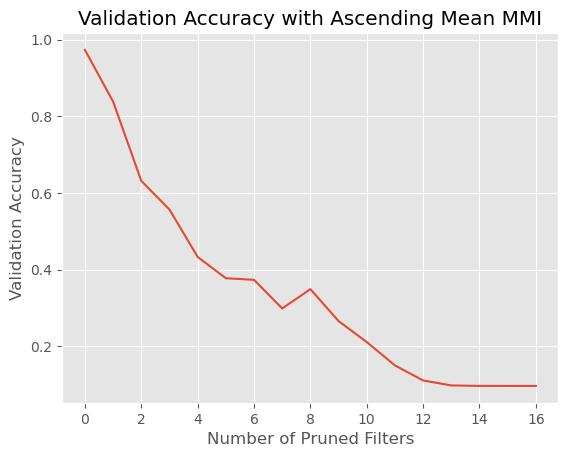

In [ ]:
prune_index_MMMI_ascending = [int(x) for x in sorted_MMMIs[:,0]]

# prune low MMMI filters
pruned_accuracies_MI_asc = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = prune_index_MMMI_ascending[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_MI_asc.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_MI_asc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Ascending Mean MMI')


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [5]
Validation accuracy: 0.9720666408538818

Removed filters: [5, 4]
Validation accuracy: 0.9669333100318909

Removed filters: [5, 4, 6]
Validation accuracy: 0.9621999859809875

Removed filters: [5, 4, 6, 2]
Validation accuracy: 0.9185333251953125

Removed filters: [5, 4, 6, 2, 7]
Validation accuracy: 0.8654666543006897

Removed filters: [5, 4, 6, 2, 7, 0]
Validation accuracy: 0.7079333066940308

Removed filters: [5, 4, 6, 2, 7, 0, 3]
Validation accuracy: 0.5705333352088928

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1]
Validation accuracy: 0.46086665987968445

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1, 9]
Validation accuracy: 0.6223999857902527

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1, 9, 8]
Validation accuracy: 0.4203333258628845

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1, 9, 8, 11]
Validation accuracy: 0.382999986410141

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1, 9, 8, 11, 10]
Validation accuracy: 0.30480000376

Text(0.5, 1.0, 'Validation Accuracy with Descending Mean MMI')

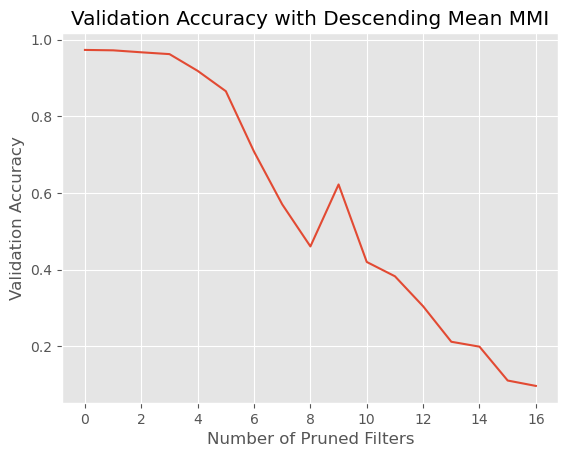

In [ ]:
prune_index_MMMI_descending = [int(x) for x in sorted_MMMIs[:,0][::-1]]

# prune low MMMI filters
pruned_accuracies_MI_desc = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = prune_index_MMMI_descending[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_MI_desc.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_MI_desc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Descending Mean MMI')

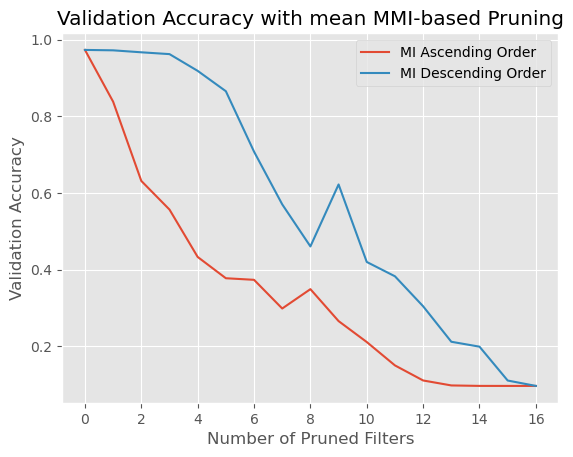

In [ ]:
# GOOD EXAMPLE HERE -- REMOVING LOW-MI FILTERS REDUCES ACCURACY MUCH FASTER
# THAN REMOVING HIGH-MI FILTERS

plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies_MI_asc, label = 'MI Ascending Order')
plt.plot(pruned_accuracies_MI_desc, label = 'MI Descending Order')

#plt.plot(pruned_accuracies, label = 'Brute Force Greedy Pruning')
#plt.plot(pruned_accuracies_entropy_mid, label = 'Middle-out Order')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with mean MMI-based Pruning')

plt.legend()

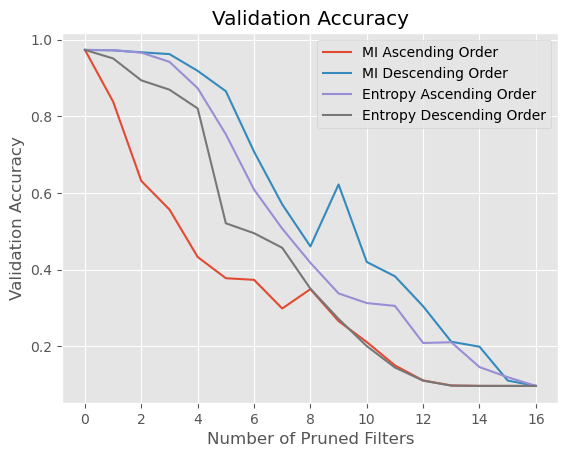

In [ ]:
# GOOD EXAMPLE HERE -- MI SEEMS MORE CONSEQUENTIAL THAN ENTROPY

plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies_MI_asc, label = 'MI Ascending Order')
plt.plot(pruned_accuracies_MI_desc, label = 'MI Descending Order')
plt.plot(pruned_accuracies_entropy_ascending, label = 'Entropy Ascending Order')
plt.plot(pruned_accuracies_entropy_descending, label = 'Entropy Descending Order')

#plt.plot(pruned_accuracies, label = 'Brute Force Greedy Pruning')
#plt.plot(pruned_accuracies_entropy_mid, label = 'Middle-out Order')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy')

plt.legend()

In [ ]:
MI_pairs = np.zeros((16, 16))

for r in means:
    i = int(r[0])
    j = int(r[1])
    MI_pairs[i, j] = r[2]
    MI_pairs[j, i] = r[2]

MI_descending = []

for i in range(16):
    MI_sums = MI_pairs.sum(axis = 0)
    max_MI_index = np.argmax(MI_sums)
    
    MI_descending.append(max_MI_index)
    
    MI_pairs[:, max_MI_index] = 0
    MI_pairs[max_MI_index, :] = 0
    
MI_descending

[5, 4, 1, 2, 3, 7, 6, 0, 8, 9, 10, 11, 14, 13, 12, 0]


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [5]
Validation accuracy: 0.9720666408538818

Removed filters: [5, 4]
Validation accuracy: 0.9669333100318909

Removed filters: [5, 4, 1]
Validation accuracy: 0.9608666896820068

Removed filters: [5, 4, 1, 2]
Validation accuracy: 0.916533350944519

Removed filters: [5, 4, 1, 2, 3]
Validation accuracy: 0.8675333261489868

Removed filters: [5, 4, 1, 2, 3, 7]
Validation accuracy: 0.7509333491325378

Removed filters: [5, 4, 1, 2, 3, 7, 6]
Validation accuracy: 0.5921333432197571

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0]
Validation accuracy: 0.46086665987968445

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0, 8]
Validation accuracy: 0.3790000081062317

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0, 8, 9]
Validation accuracy: 0.4203333258628845

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0, 8, 9, 10]
Validation accuracy: 0.3470666706562042

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0, 8, 9, 10, 11]
Validation accuracy: 0.30480000376

Text(0.5, 1.0, 'Validation Accuracy with Descending Mean MMI (Proper)')

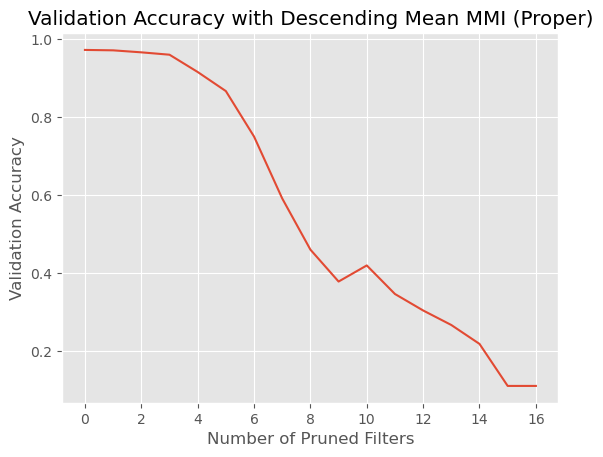

In [ ]:
# prune low MMMI filters
pruned_accuracies_MI_desc_proper = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = MI_descending[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_MI_desc_proper.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_MI_desc_proper)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Descending Mean MMI (Proper)')

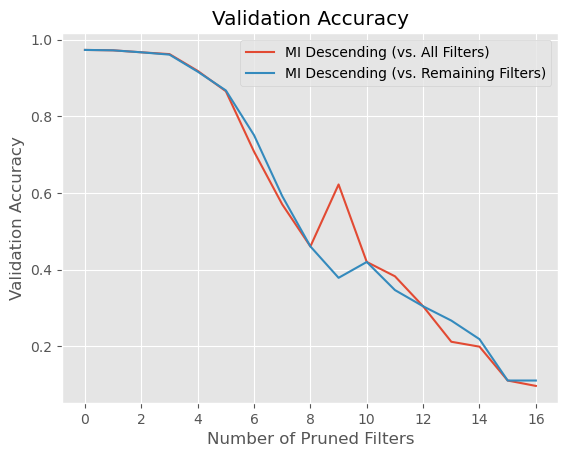

In [ ]:
# GOOD EXAMPLE HERE -- MI SEEMS MORE CONSEQUENTIAL THAN ENTROPY

plt.style.use('ggplot')
plt.figure()

#plt.plot(pruned_accuracies_MI_asc, label = 'MI Ascending Order')
plt.plot(pruned_accuracies_MI_desc, label = 'MI Descending (vs. All Filters)')
#plt.plot(pruned_accuracies_entropy_ascending, label = 'Entropy Ascending')
#plt.plot(pruned_accuracies_entropy_descending, label = 'Entropy Descending Order')
plt.plot(pruned_accuracies_MI_desc_proper, label = 'MI Descending (vs. Remaining Filters)')

#plt.plot(pruned_accuracies, label = 'Brute Force Greedy Pruning')
#plt.plot(pruned_accuracies_entropy_mid, label = 'Middle-out Order')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy')

plt.legend()

In [ ]:
# Prune Based on 

## PCA of filter entropies

## (This code for entropies at different layers is not integrated with the code above yet)

In [ ]:
from scipy.special import entr

In [ ]:
# all layers
#indices = range(11)

# pooling and activations
indices = [1,2,4,5,6,8,10]

# activations only
#indices = [1, 4, 8, 10]

for l in range(7):
    # print the mean entropy of the data
    if l == -1:
        print('input data')
        entropy = entr(trainX).sum(axis = 0).mean()
        print('Mean input data entropy is', entropy)
        continue

    # print layer number and grab the activations from this layer
    else:
        print('\nlayer', l)
        print(model.layers[l])
        activation = activations[l]

    # scale values between 0 and 1 ONLY for conv and dense layers
    if l not in indices:
        # uncomment this "continue" if you want to skip pre-activation conv and dense layers
        #continue
        print('*** Performing min-max scaling for pre-activation conv or dense layer ***')
        max_act = np.amax(activation)
        min_act = np.amin(activation)
        activation = (activation - min_act) / (max_act - min_act)

    # compute entropy summed across axis images (axis 0)
    entropy = entr(activation).sum(axis = 0)

    # compute mean entropy of layer
    layer_entropy = entropy.mean()
    print('Mean layer output entropy is', layer_entropy)


layer 0
*** Performing min-max scaling for pre-activation conv or dense layer ***
Mean layer output entropy is 1265.2261

layer 1
Mean layer output entropy is -inf

layer 2
Mean layer output entropy is 11220.089

layer 3
*** Performing min-max scaling for pre-activation conv or dense layer ***
Mean layer output entropy is 11137.508

layer 4
Mean layer output entropy is 11137.747

layer 5
Mean layer output entropy is -inf

layer 6
Mean layer output entropy is 390.6034


# Filter-Level Entropy Analysis and Pruning

## Preparation

### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

### Data preparation

In [ ]:
# load MNIST
((trainX, trainY), (testX, testY)) = mnist.load_data()

# edit shapes to make Keras happy
trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

# do a train/validation split with the same random state as the trained model
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, random_state = 0)

# save the integer labels
trainY_int = trainY
validationY_int = validationY
testY_int = testY

# turn labels into one-hot vectors
trainY = to_categorical(trainY, 10)
validationY = to_categorical(validationY, 10)
testY = to_categorical(testY, 10)

## Extract weights from the network

In [ ]:
# load a model
model = load_model('CNN_MNIST_baseline')

In [ ]:
# for each layer, print some stuff
for layer in model.layers:
    # print the name of the layer
    print('Layer name:\t', layer.name)

    # print the output shape of the layer
    print('Layer shape:\t', layer.output.shape)

Layer name:	 rescaling_44
Layer shape:	 (None, 28, 28, 1)
Layer name:	 conv2d_502
Layer shape:	 (None, 26, 26, 16)
Layer name:	 activation_366
Layer shape:	 (None, 26, 26, 16)
Layer name:	 max_pooling2d_502
Layer shape:	 (None, 13, 13, 16)
Layer name:	 flatten_263
Layer shape:	 (None, 2704)
Layer name:	 dense_263
Layer shape:	 (None, 10)
Layer name:	 activation_367
Layer shape:	 (None, 10)


In [ ]:
weights = model.get_weights()

print('Shapes of each weight array:\n')
[print(x.shape) for x in weights]
print('\n')

# weights[0] = weights for the convolutions
# weights[1] = biases for the convolutions
# weights[2] = weights and biases for the dense layer
# weights[3] = biases for the output

# filters are in weights[0]
for filter_number in range(16):
    print('Filter', filter_number, 'has weights:\n')
    print(weights[0][:, :, 0, filter_number], '\n')

#weights[0][:, :, 0, filter_number] *= 0

Shapes of each weight array:

(3, 3, 1, 16)
(16,)
(2704, 10)
(10,)


Filter 0 has weights:

[[0.08399448 0.28148448 1.0837278 ]
 [1.6085213  1.8095822  1.988991  ]
 [1.8953444  1.5176272  1.4485273 ]] 

Filter 1 has weights:

[[-0.59411085  0.38023028  1.2108037 ]
 [ 0.7789616   2.1166997   1.5399355 ]
 [ 1.2572244   1.6138644   0.56757987]] 

Filter 2 has weights:

[[-2.222721  -1.6915365 -3.0677345]
 [-2.570781  -1.1528153 -1.5423218]
 [ 0.9082809  2.1922708  1.06483  ]] 

Filter 3 has weights:

[[-1.0966239   0.1648427   0.7983462 ]
 [ 1.0791886   3.0585845   2.343832  ]
 [-0.34608862  1.3927871   0.9920167 ]] 

Filter 4 has weights:

[[-0.9111253  -0.2632278  -0.02609901]
 [-1.9972112  -1.8719246  -2.412887  ]
 [ 0.5390199  -0.34724462 -1.0287819 ]] 

Filter 5 has weights:

[[-0.14685151 -1.3828248  -1.6562883 ]
 [-0.54765296 -1.2531892  -0.36301008]
 [-1.4888862  -1.5506439   0.05207771]] 

Filter 6 has weights:

[[1.5161341 1.3948911 1.6433269]
 [2.2460861 1.887583  1.4928001]
 [

## Greedy Pruning

In [ ]:
def greedy_pruning_shallow_conv(model_path, validationX, validationY, num_filters):

    print('\n=================================== CNN Accuracy ===================================\n')

    model = load_model(model_path)

    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    print('Validation accuracy of full net:', format(validation_accuracy, '.4f'))

    pruned_accuracies = [validation_accuracy]

    # initialize filter numbers
    filters = [i for i in range(num_filters)]
    removed_filters = []

    for i in range(15):

        print('\n================================ Greedy Iteration', i + 1, '================================')

        # initialize best val accuracy and worst filter
        best_validation_accuracy = 0
        worst_filter = None

        # find the worst filter in a greedy sense
        for filter_number in filters:

            # load full model
            model = load_model(model_path)

            # get the weights
            weights = model.get_weights()

            # set the removed filter and current filter weights and biases to 0
            weights[0][:, :, 0, removed_filters + [filter_number]] *= 0
            weights[1][removed_filters + [filter_number]] *= 0
            model.set_weights(weights)

            # compute validation accuracy after removing the current filter
            validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]

            #print('Removing filter', filter_number, 'gives validation accuracy', format(validation_accuracy, '.4f'))

            # if this val accuracy is the highest we have seen, set the current filter as the "worst"
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                worst_filter = filter_number

        # delete the worst filter
        filters.remove(worst_filter)
        removed_filters.append(worst_filter)

        print('\nRemoving filter:', worst_filter, '\nValidation accuracy:', format(best_validation_accuracy, '.4f'))
        pruned_accuracies.append(best_validation_accuracy)

        #print('\nRemaining filters:', filters)

    # if there are no convolutonal filters, the model will predict the same output everytime
    # (biases to the output layer will control this as everything else is 0)

    pruned_accuracies.append(0.1)

    plt.style.use('ggplot')
    plt.figure()
    plt.plot(pruned_accuracies)
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Number of Pruned Filters')
    plt.title('Validation Accuracy with Greedy Filter Pruning')
    
    return pruned_accuracies, removed_filters


=================================== CNN Accuracy ===================================

Validation accuracy of full net: 0.9731

================================ Greedy Iteration 1 ================================

Removing filter: 3 
Validation accuracy: 0.9733

================================ Greedy Iteration 2 ================================

Removing filter: 4 
Validation accuracy: 0.9705

================================ Greedy Iteration 3 ================================

Removing filter: 5 
Validation accuracy: 0.9615

================================ Greedy Iteration 4 ================================

Removing filter: 10 
Validation accuracy: 0.9467

================================ Greedy Iteration 5 ================================

Removing filter: 11 
Validation accuracy: 0.9195

================================ Greedy Iteration 6 ================================

Removing filter: 7 
Validation accuracy: 0.8872

================================ Greedy Iteration 7 ========

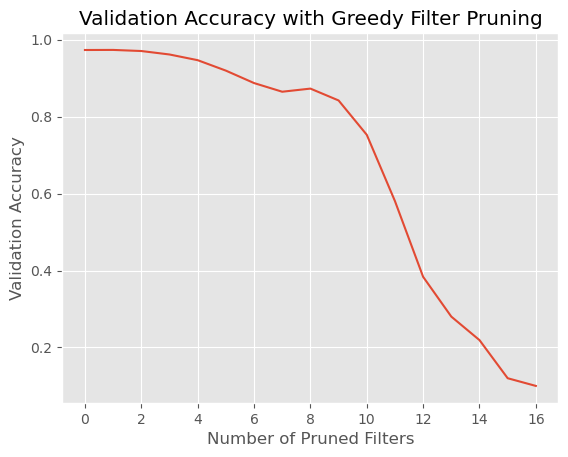

In [ ]:
# run greedy pruning
pruned_accuracies, removed_filters = greedy_pruning_shallow_conv('CNN_MNIST_baseline', validationX, validationY, 16)

print(pruned_accuracies)


=================================== CNN Accuracy ===================================

Validation accuracy of full net: 0.9833

================================ Greedy Iteration 1 ================================

Removing filter: 11 
Validation accuracy: 0.9785

================================ Greedy Iteration 2 ================================

Removing filter: 7 
Validation accuracy: 0.9637

================================ Greedy Iteration 3 ================================

Removing filter: 8 
Validation accuracy: 0.9123

================================ Greedy Iteration 4 ================================

Removing filter: 1 
Validation accuracy: 0.8495

================================ Greedy Iteration 5 ================================

Removing filter: 2 
Validation accuracy: 0.7633

================================ Greedy Iteration 6 ================================

Removing filter: 9 
Validation accuracy: 0.6447

================================ Greedy Iteration 7 =========

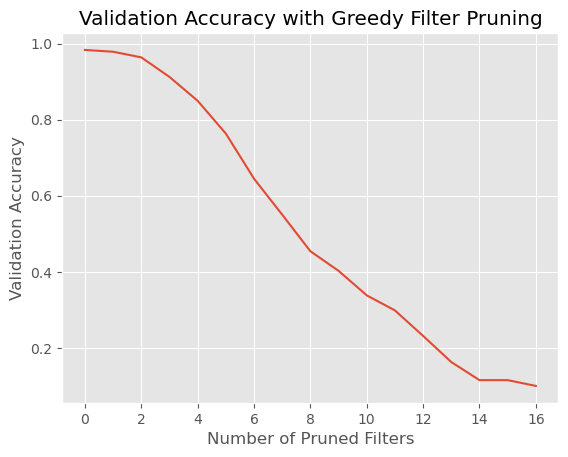

In [ ]:
# this thing gets so mad and spits out many warnings, but they don't seem to harm anything

pruned_accuracies_reg, removed_filters = greedy_pruning_shallow_conv('CNN_MNIST_regularized_baseline', validationX, validationY, 16)

print(pruned_accuracies_reg)

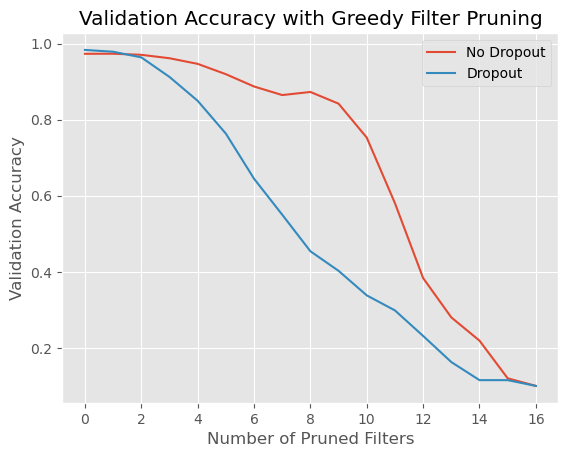

In [ ]:
plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies, label = 'No Dropout')
plt.plot(pruned_accuracies_reg, label = 'Dropout')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Greedy Filter Pruning')

plt.legend()

## Extract layer outputs

In [ ]:
# load a model
model = load_model('CNN_MNIST_baseline')

# Extracts the outputs of all layers
layer_outputs = [layer.output for layer in model.layers] 

# Creates a model that will return these outputs, given the model input
activation_model = model.Model(inputs = model.input, outputs = layer_outputs)

# returns a list of Numpy arrays: 4one array per layer activation
#activations = activation_model.predict(trainX[trainY == 0])
activations = activation_model.predict(trainX)

AttributeError: 'Sequential' object has no attribute 'Model'

In [ ]:
# check the layer names and data representation shapes
for layer, activation in zip(model.layers, activations):
    print(layer)
    print(activation.shape)

NameError: name 'activations' is not defined

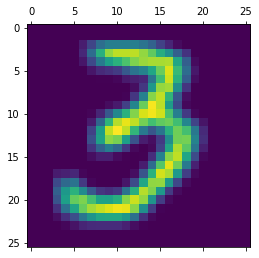

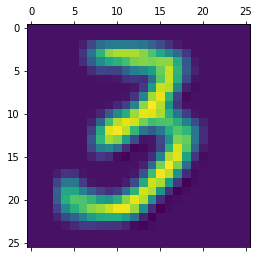

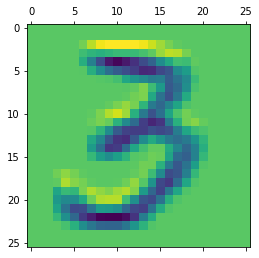

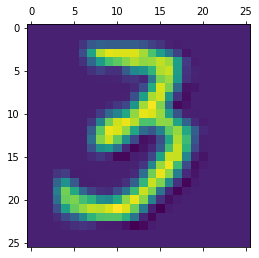

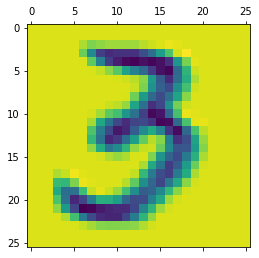

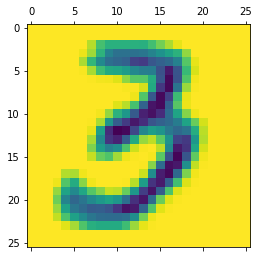

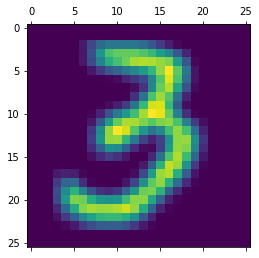

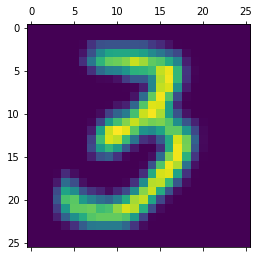

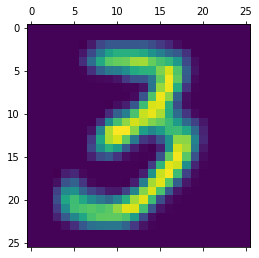

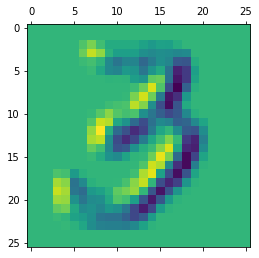

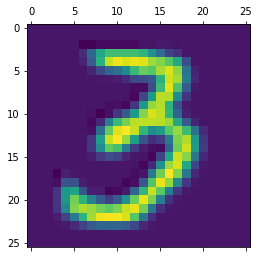

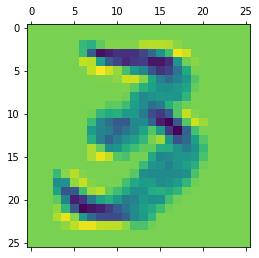

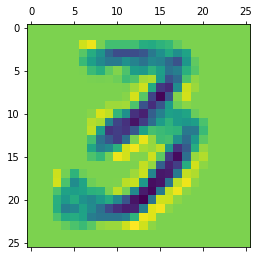

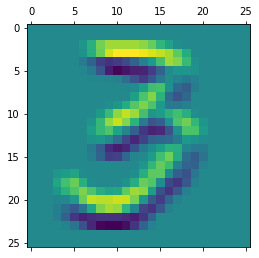

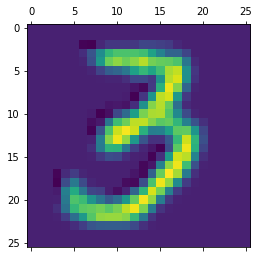

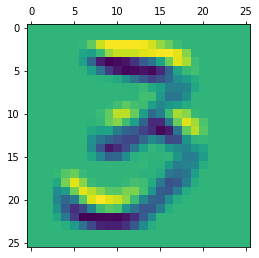

In [ ]:
l = 1
img = 0

activation = activations[l]

for j in range(activation.shape[-1]):
    plt.matshow(activation[img, :, :, j])

In [ ]:
l = -1
img = 0

activation = activations[l]

activation.mean(axis = 0)

array([0.10089353, 0.10846104, 0.10536999, 0.10169567, 0.09825314,
       0.08931642, 0.09643674, 0.10228993, 0.10210565, 0.09514087],
      dtype=float32)

## Entropies for Convolutional Feature Maps

In [ ]:
from scipy.special import entr

train_activations = activation_model.predict(trainX)
test_activations = activation_model.predict(testX)

predicted_trainY = model.predict(trainX).argmax(axis = 1)
predicted_testY = model.predict(testX).argmax(axis = 1)

layer = 2

train_activation = train_activations[layer]
test_activation = test_activations[layer]

313/313 [==============================] - 0s 1ms/step


### Filter entropies for train vs test set and correct vs incorrect classifications

Let's find filter-level entropies for training data with correct/incorrect predictions and the same for the test set

In [ ]:
good_train_predictions = predicted_trainY == trainY.argmax(axis = 1)
bad_train_predictions = predicted_trainY != trainY.argmax(axis = 1)

good_train_activation = train_activation[good_train_predictions]
bad_train_activation = train_activation[bad_train_predictions]

good_test_predictions = predicted_testY == testY.argmax(axis = 1)
bad_test_predictions = predicted_testY != testY.argmax(axis = 1)

good_test_activation = test_activation[good_test_predictions]
bad_test_activation = test_activation[bad_test_predictions]

from scipy.special import entr

good_train_entropy_list = []
bad_train_entropy_list = []
good_test_entropy_list = []
bad_test_entropy_list = []

for j in range(good_train_activation.shape[-1]):
    good_train_filter_activation = np.array(good_train_activation[:, :, :, j])
    good_train_filter_entropy = entr(good_train_filter_activation).sum(axis = 0).mean()
    good_train_entropy_list.append(good_train_filter_entropy)
    
for j in range(bad_train_activation.shape[-1]):
    bad_train_filter_activation = np.array(bad_train_activation[:, :, :, j])
    bad_train_filter_entropy = entr(bad_train_filter_activation).sum(axis = 0).mean()
    bad_train_entropy_list.append(bad_train_filter_entropy)
    
for j in range(good_test_activation.shape[-1]):
    good_test_filter_activation = np.array(good_test_activation[:, :, :, j])
    good_test_filter_entropy = entr(good_test_filter_activation).sum(axis = 0).mean()
    good_test_entropy_list.append(good_test_filter_entropy)

for j in range(bad_test_activation.shape[-1]):
    bad_test_filter_activation = np.array(bad_test_activation[:, :, :, j])
    bad_test_filter_entropy = entr(bad_test_filter_activation).sum(axis = 0).mean()
    bad_test_entropy_list.append(bad_test_filter_entropy)

(0.0, 16000.0)

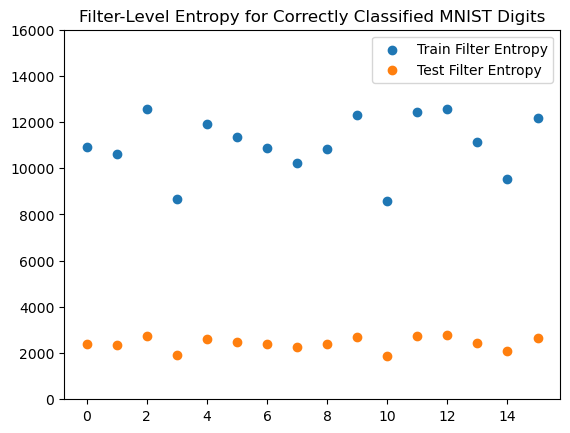

In [ ]:
plt.scatter(range(16), good_train_entropy_list, label = 'Train Filter Entropy')
plt.scatter(range(16), good_test_entropy_list, label = 'Test Filter Entropy')
plt.legend()
plt.title('Filter-Level Entropy for Correctly Classified MNIST Digits')
plt.ylim(0,16000)

(0.0, 260.0)

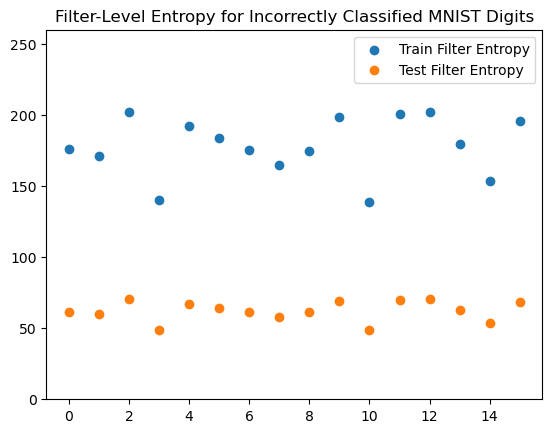

In [ ]:
plt.scatter(range(16), bad_train_entropy_list, label = 'Train Filter Entropy')
plt.scatter(range(16), bad_test_entropy_list, label = 'Test Filter Entropy')
plt.legend()
plt.title('Filter-Level Entropy for Incorrectly Classified MNIST Digits')
plt.ylim(0,260)

It seems the same entropy patterns hold across correctly and incorrectly classified MNIST characters.

In [ ]:
good_train_predictions = predictedY_int == validationY_int
bad_train_predictions = predictedY_int == validationY_int
    
sum(good_train_predictions)

NameError: name 'predictedY_int' is not defined

## Effects of Pruning Individual Filters

In [ ]:
from sklearn.metrics import confusion_matrix

############################## prune filters individually ##############################
print('Computing pruned metrics')

validation_accuracies = []

class_accuracies = []

class_mses = []
mean_mses = []

correct_mses = []
incorrect_mses = []

mean_correct_mses = []
mean_incorrect_mses = []

predicted_dist_entropy_means = []
correct_predicted_dist_entropy_means = []
incorrect_predicted_dist_entropy_means = []

validationY_int = validationY.argmax(axis = 1)

for i in range(16):
    
    print('Pruning filter', i)
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, i] *= 0
    weights[1][i] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    validation_accuracies.append(validation_accuracy)
    
    # compute class-level accuracies
    predictedY = model.predict(validationX)
    predictedY_int = predictedY.argmax(axis = 1)
    
    confusion_mat = confusion_matrix(validationY_int, predictedY_int)
    class_accuracies_prune = confusion_mat.diagonal()/confusion_mat.sum(axis = 1)
    
    class_accuracies.append(class_accuracies_prune)
    
    # compute class-level MSEs
    class_mses_prune = np.linalg.norm(predictedY - validationY, axis = 0) ** 2 / validationY.shape[0]
    class_mses.append(class_mses_prune)
    
    mean_mses.append(class_mses_prune.mean())
    
    # compute class-level MSEs of correct and incorrect predictions separately
    good_val_predictions = predictedY_int == validationY_int
    bad_val_predictions = predictedY_int != validationY_int
    
    correct_mses_prune = np.linalg.norm((predictedY - validationY)[good_val_predictions], axis = 0) ** 2 / sum(good_val_predictions)
    correct_mses.append(correct_mses_prune)
    
    mean_correct_mses.append(correct_mses_prune.mean())
    
    incorrect_mses_prune = np.linalg.norm((predictedY - validationY)[bad_val_predictions], axis = 0) ** 2 / sum(bad_val_predictions)
    incorrect_mses.append(incorrect_mses_prune)
    
    mean_incorrect_mses.append(incorrect_mses_prune.mean())
    
    # compute predicted Y mean entropy for all, correct, and incorrect predictions
    predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY]).mean())
    correct_predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY[good_val_predictions]]).mean())
    incorrect_predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY[bad_val_predictions]]).mean())
    
############################## compute filter-level entropies ##############################
print('Computing filter-level entropies')

# load the model
model = load_model('CNN_MNIST_baseline')

# extract the activations for the specified layer
layer = 2
activation = activations[layer]

# initilize a list of entropies
entropy_list = []

# loop over the filters to build a list of [filter number, entropy]
for j in range(activation.shape[-1]):
    # extract activations for the jth filter
    filter_activation = np.array(activation[:, :, :, j])
    
    # find the entropy of the activations of the filter
    filter_entropy = entr(filter_activation).sum(axis = 0).mean()
    
    # add [filter number, entropy] to the list
    entropy_list.append(filter_entropy)

Computing pruned metrics
Pruning filter 0


2023-04-21 21:07:43.000681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 21:07:43.000998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 21:07:43.001293: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-21 21:07:43.001356: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-21 21:07:43.001411: W tensorflow/compiler/xl

469/469 [==============================] - 1s 1ms/step
Pruning filter 1
469/469 [==============================] - 1s 1ms/step
Pruning filter 2
469/469 [==============================] - 1s 1ms/step
Pruning filter 3
469/469 [==============================] - 1s 1ms/step
Pruning filter 4
469/469 [==============================] - 1s 1ms/step
Pruning filter 5
469/469 [==============================] - 1s 1ms/step
Pruning filter 6
469/469 [==============================] - 1s 1ms/step
Pruning filter 7
469/469 [==============================] - 1s 1ms/step
Pruning filter 8
469/469 [==============================] - 1s 1ms/step
Pruning filter 9
469/469 [==============================] - 1s 1ms/step
Pruning filter 10
469/469 [==============================] - 1s 1ms/step
Pruning filter 11
469/469 [==============================] - 1s 1ms/step
Pruning filter 12
469/469 [==============================] - 1s 1ms/step
Pruning filter 13
469/469 [==============================] - 1s 1ms/step
Pruni

NameError: name 'activations' is not defined

In [ ]:
import pandas as pd

df = pd.DataFrame(zip(entropy_list, validation_accuracies, mean_mses, mean_correct_mses, mean_incorrect_mses, predicted_dist_entropy_means,
                      correct_predicted_dist_entropy_means, incorrect_predicted_dist_entropy_means),
                  columns = ['Filter Entropy', 'Val accuracy', 'MSE', 'Correct MSE', 'Incorrect MSE', 'Output Entropy', 'Correct Output Entropy', 'Incorrect Output Entropy'])

df = pd.concat([df, pd.DataFrame(class_accuracies, columns = ['0 acc', '1 acc', '2 acc', '3 acc', '4 acc', '5 acc', '6 acc', '7 acc', '8 acc', '9 acc'])], axis = 1)

df = pd.concat([df, pd.DataFrame(class_mses, columns = ['0 MSE', '1 MSE', '2 MSE', '3 MSE', '4 MSE', '5 MSE', '6 MSE', '7 MSE', '8 MSE', '9 MSE'])], axis = 1)

df = pd.concat([df, pd.DataFrame(correct_mses, columns = ['0 correct MSE', '1 correct MSE', '2 correct MSE', '3 correct MSE', '4 correct MSE',
                                                          '5 correct MSE', '6 correct MSE', '7 correct MSE', '8 correct MSE', '9 correct MSE'])], axis = 1)

df = pd.concat([df, pd.DataFrame(incorrect_mses, columns = ['0 incorrect MSE', '1 incorrect MSE', '2 incorrect MSE', '3 incorrect MSE', '4 incorrect MSE',
                                                            '5 incorrect MSE', '6 incorrect MSE', '7 incorrect MSE', '8 incorrect MSE', '9 incorrect MSE'])], axis = 1)


df

#df.to_csv('Single_Filter_Prune_Metrics.csv')

Filter Entropy  Val accuracy       MSE  Correct MSE  Incorrect MSE  \
0     11079.274414      0.969667  0.004658     0.001075       0.119178   
1     10771.479492      0.971400  0.004394     0.000990       0.120005   
2     12758.914062      0.959800  0.006339     0.001475       0.122454   
3      8806.171875      0.973333  0.004333     0.001012       0.125543   
4     12107.949219      0.972200  0.004204     0.000899       0.119783   
5     11552.464844      0.972067  0.004463     0.001035       0.123737   
6     11047.671875      0.970267  0.004539     0.001027       0.119151   
7     10386.335938      0.970067  0.004588     0.000991       0.121165   
8     11004.882812      0.968333  0.004762     0.001027       0.118979   
9     12483.358398      0.895867  0.015838     0.002099       0.134035   
10     8719.502930      0.972533  0.004208     0.000864       0.122611   
11    12657.209961      0.957867  0.006368     0.001359       0.120244   
12    12776.925781      0.950933  0.007694     0.001752       0.122855   
13    11325.502930      0.952533  0.007459     0.001859       0.119838   
14     9683.320312      0.972933  0.004230     0.000938       0.122577   
15    12360.447266      0.838200  0.023154     0.004406       0.120281   

    Output Entropy  Correct Output Entropy  Incorrect Output Entropy  \
0         0.117758                0.098284                  0.740267   
1         0.110008                0.091784                  0.728988   
2         0.146989                0.121877                  0.746564   
3         0.105086                0.088624                  0.705964   
4         0.097391                0.079454                  0.724696   
5         0.106344                0.089149                  0.704720   
6         0.113426                0.094459                  0.732358   
7         0.109012                0.090168                  0.719715   
8         0.113736                0.093584                  0.729955   
9         0.180246                0.131084                  0.603188   
10        0.096095                0.078846                  0.706827   
11        0.135218                0.109025                  0.730690   
12        0.165287                0.136128                  0.730404   
13        0.173271                0.142900                  0.782737   
14        0.099032                0.082248                  0.702360   
15        0.344762                0.248229                  0.844851   

       0 acc     1 acc  ...  0 incorrect MSE  1 incorrect MSE  \
0   0.985430  0.987847  ...         0.077400         0.057421   
1   0.986093  0.989583  ...         0.078956         0.054387   
2   0.983444  0.944444  ...         0.050700         0.114334   
3   0.983444  0.988426  ...         0.074866         0.059333   
4   0.994040  0.984954  ...         0.084509         0.058702   
5   0.994702  0.984375  ...         0.096568         0.061323   
6   0.986755  0.989005  ...         0.081220         0.063522   
7   0.985430  0.986690  ...         0.076410         0.066527   
8   0.986093  0.989005  ...         0.080501         0.060854   
9   0.999338  0.972222  ...         0.064168         0.033216   
10  0.983444  0.987269  ...         0.069748         0.062418   
11  0.990728  0.939236  ...         0.047325         0.114397   
12  0.981457  0.960648  ...         0.046097         0.067633   
13  0.984106  0.946181  ...         0.048911         0.092237   
14  0.985430  0.987269  ...         0.075529         0.064196   
15  0.893377  0.488426  ...         0.046193         0.272242   

    2 incorrect MSE  3 incorrect MSE  4 incorrect MSE  5 incorrect MSE  \
0          0.231439         0.109571         0.110362         0.103151   
1          0.231642         0.109596         0.119232         0.110936   
2          0.204438         0.164460         0.104324         0.126398   
3          0.239961         0.112191         0.121534         0.119815   
4          0.190329         0.114478        

In [ ]:
from sklearn.metrics import confusion_matrix

############################## prune filters in pairs ##############################
print('Computing pruned metrics')

validation_accuracies = []

class_accuracies = []

class_mses = []
mean_mses = []

correct_mses = []
incorrect_mses = []

mean_correct_mses = []
mean_incorrect_mses = []

predicted_dist_entropy_means = []
correct_predicted_dist_entropy_means = []
incorrect_predicted_dist_entropy_means = []

validationY_int = validationY.argmax(axis = 1)

for i in range(16):
    for j in range(i + 1, 16):
    
        print('Pruning filters', i, 'and', j)

        # load full model
        model = load_model('CNN_MNIST_baseline')

        # get the weights
        weights = model.get_weights()

        # set the removed filter and current filter weights and biases to 0
        weights[0][:, :, 0, [i, j]] *= 0
        weights[1][[i, j]] *= 0
        model.set_weights(weights)

        # compute validation accuracy after removing the current filter
        validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
        validation_accuracies.append(validation_accuracy)

        # compute class-level accuracies
        predictedY = model.predict(validationX)
        predictedY_int = predictedY.argmax(axis = 1)

        confusion_mat = confusion_matrix(validationY_int, predictedY_int)
        class_accuracies_prune = confusion_mat.diagonal()/confusion_mat.sum(axis = 1)

        class_accuracies.append(class_accuracies_prune)

        # compute class-level MSEs
        class_mses_prune = np.linalg.norm(predictedY - validationY, axis = 0) ** 2 / validationY.shape[0]
        class_mses.append(class_mses_prune)

        mean_mses.append(class_mses_prune.mean())

        # compute class-level MSEs of correct and incorrect predictions separately
        good_val_predictions = predictedY_int == validationY_int
        bad_val_predictions = predictedY_int != validationY_int

        correct_mses_prune = np.linalg.norm((predictedY - validationY)[good_val_predictions], axis = 0) ** 2 / sum(good_val_predictions)
        correct_mses.append(correct_mses_prune)

        mean_correct_mses.append(correct_mses_prune.mean())

        incorrect_mses_prune = np.linalg.norm((predictedY - validationY)[bad_val_predictions], axis = 0) ** 2 / sum(bad_val_predictions)
        incorrect_mses.append(incorrect_mses_prune)

        mean_incorrect_mses.append(incorrect_mses_prune.mean())

        # compute predicted Y mean entropy for all, correct, and incorrect predictions
        predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY]).mean())
        correct_predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY[good_val_predictions]]).mean())
        incorrect_predicted_dist_entropy_means.append(np.array([sum(-x * np.log(x)) for x in predictedY[bad_val_predictions]]).mean())

Computing pruned metrics
Pruning filters 0 and 1
Pruning filters 0 and 2
Pruning filters 0 and 3
Pruning filters 0 and 4
Pruning filters 0 and 5
Pruning filters 0 and 6
Pruning filters 0 and 7
Pruning filters 0 and 8
Pruning filters 0 and 9
Pruning filters 0 and 10
Pruning filters 0 and 11
Pruning filters 0 and 12
Pruning filters 0 and 13
Pruning filters 0 and 14
Pruning filters 0 and 15
Pruning filters 1 and 2
Pruning filters 1 and 3
Pruning filters 1 and 4
Pruning filters 1 and 5
Pruning filters 1 and 6
Pruning filters 1 and 7
Pruning filters 1 and 8
Pruning filters 1 and 9
Pruning filters 1 and 10
Pruning filters 1 and 11
Pruning filters 1 and 12
Pruning filters 1 and 13
Pruning filters 1 and 14
Pruning filters 1 and 15
Pruning filters 2 and 3
Pruning filters 2 and 4
Pruning filters 2 and 5
Pruning filters 2 and 6
Pruning filters 2 and 7
Pruning filters 2 and 8
Pruning filters 2 and 9
Pruning filters 2 and 10
Pruning filters 2 and 11
Pruning filters 2 and 12
Pruning filters 2 and 13

In [ ]:
############################## compute filter-level entropies ##############################

print('Computing filter-level entropies')

# load the model
model = load_model('CNN_MNIST_baseline')

# extract the activations for the specified layer
layer = 2
activation = activations[layer]

# initilize a list of entropies
entropy_list = []

# loop over the filters to build a list of [filter number, entropy]
for j in range(activation.shape[-1]):
    # extract activations for the jth filter
    filter_activation = np.array(activation[:, :, :, j])
    
    # find the entropy of the activations of the filter
    filter_entropy = entr(filter_activation).sum(axis = 0).mean()
    
    # add [filter number, entropy] to the list
    entropy_list.append(filter_entropy)
    
# initilize a list of entropies
filter_number_1 = []
filter_number_2 = []
entropy_list_1 = []
entropy_list_2 = []

for i in range(16):
    for j in range(i + 1, 16):
        entropy_list_1.append(entropy_list[i])
        entropy_list_2.append(entropy_list[j])
        filter_number_1.append(i)
        filter_number_2.append(j)

Computing filter-level entropies


In [ ]:
import pandas as pd

df = pd.DataFrame(zip(filter_number_1, filter_number_2, entropy_list_1, entropy_list_2, validation_accuracies, mean_mses, mean_correct_mses, mean_incorrect_mses,
                      predicted_dist_entropy_means, correct_predicted_dist_entropy_means, incorrect_predicted_dist_entropy_means),
                  columns = ['Filter 1', 'Filter 2', 'Filter 1 Entropy', 'Filter 2 Entropy', 'Val accuracy', 'MSE', 'Correct MSE',
                             'Incorrect MSE', 'Output Entropy', 'Correct Output Entropy', 'Incorrect Output Entropy'])

df = pd.concat([df, pd.DataFrame(class_accuracies, columns = ['0 acc', '1 acc', '2 acc', '3 acc', '4 acc', '5 acc', '6 acc', '7 acc', '8 acc', '9 acc'])], axis = 1)

df = pd.concat([df, pd.DataFrame(class_mses, columns = ['0 MSE', '1 MSE', '2 MSE', '3 MSE', '4 MSE', '5 MSE', '6 MSE', '7 MSE', '8 MSE', '9 MSE'])], axis = 1)

df = pd.concat([df, pd.DataFrame(correct_mses, columns = ['0 correct MSE', '1 correct MSE', '2 correct MSE', '3 correct MSE', '4 correct MSE',
                                                          '5 correct MSE', '6 correct MSE', '7 correct MSE', '8 correct MSE', '9 correct MSE'])], axis = 1)

df = pd.concat([df, pd.DataFrame(incorrect_mses, columns = ['0 incorrect MSE', '1 incorrect MSE', '2 incorrect MSE', '3 incorrect MSE', '4 incorrect MSE',
                                                            '5 incorrect MSE', '6 incorrect MSE', '7 incorrect MSE', '8 incorrect MSE', '9 incorrect MSE'])], axis = 1)


df

df.to_csv('Double_Filter_Prune_Metrics.csv')

In [ ]:
df

Filter 1  Filter 2  Filter 1 Entropy  Filter 2 Entropy  Val accuracy  \
0           0         1      11079.275391      10771.479492      0.950333   
1           0         2      11079.275391      12758.914062      0.935000   
2           0         3      11079.275391       8806.171875      0.956067   
3           0         4      11079.275391      12107.949219      0.968533   
4           0         5      11079.275391      11552.464844      0.965067   
..        ...       ...               ...               ...           ...   
115        12        14      12776.925781       9683.320312      0.943600   
116        12        15      12776.925781      12360.447266      0.723800   
117        13        14      11325.502930       9683.320312      0.934200   
118        13        15      11325.502930      12360.447266      0.631533   
119        14        15       9683.320312      12360.447266      0.810200   

          MSE  Correct MSE  Incorrect MSE  Output Entropy  \
0    0.007785     0.001945       0.119522        0.178496   
1    0.009878     0.002434       0.116955        0.220575   
2    0.006974     0.001724       0.121210        0.163375   
3    0.005003     0.001176       0.122799        0.127024   
4    0.005618     0.001369       0.122976        0.142041   
..        ...          ...            ...             ...   
115  0.008673     0.002071       0.119132        0.187422   
116  0.039543     0.006290       0.126683        0.430593   
117  0.010049     0.002403       0.118602        0.213590   
118  0.052353     0.005540       0.132589        0.462182   
119  0.027227     0.005867       0.118406        0.402450   

     Correct Output Entropy  ...  0 incorrect MSE  1 incorrect MSE  \
0                  0.149385  ...         0.057716         0.046126   
1                  0.181802  ...         0.044023         0.059848   
2                  0.137845  ...         0.074011         0.047862   
3                  0.106904  ...         0.077562         0.059725   
4                  0.120515  ...         0.078522         0.056214   
..                      ...  ...              ...              ...   
115                0.153827  ...         0.045990         0.044899   
116                0.313219  ...         0.082262         0.202871   
117                0.171813  ...         0.044018         0.052139   
118                0.270848  ...         0.079526         0.242253   
119                0.301160  ...         0.074951         0.188656   

     2 incorrect MSE  3 incorrect MSE  4 incorrect MSE  5 incorrect MSE  \
0           0.290745         0.091603         0.092678         0.089506   
1           0.221448         0.164475         0.078250         0.107711   
2           0.291667         0.094998         0.094613         0.102132   
3           0.213000         0.111137         0.109393         0.125194   
4           0.235527         0.105265         0.106880         0.105530   
..               ...              ...              ...              ...   
115         0.248572         0.127223         0.077748         0.115185   
116         0.345908         0.123633         0.044811         0.051433   
117         0.220865         0.090761         0.112940         0.138287   
118         0.214623         0.183668         0.087175         0.106704   
119         0.184675         0.113340         0.077255         0.110939   

     6 incorrect MSE  7 incorrect MSE  8 incorrect MSE  9 incorrect MSE  
0           0.067613         0.096222         0.188774         0.174232  
1           0.091795         0.092249         0.193111         0.116646  
2           0.064967         0.109017         0.159324         0.173508  
3           0.100110         0.121975         0.140888         0.169003  
4           0.086318         0.127139         0.151218         0.177147  
..               ...              ...              ...              ...  
115         0.071815         0.129791         0.119159         0.210936  
116         0

## Entropy-based Pruning

In [ ]:
from scipy.special import entr

# extract the activations for the specified layer
layer = 2
activation = activations[layer]

# initilize a list of entropies
entropy_list = []

# loop over the filters to build a list of [filter number, entropy]
for j in range(activation.shape[-1]):
    # extract activations for the jth filter
    filter_activation = np.array(activation[:, :, :, j])
    
    # find the entropy of the activations of the filter
    filter_entropy = entr(filter_activation).sum(axis = 0).mean()
    
    # add [filter number, entropy] to the list
    entropy_list.append([j, filter_entropy])
    
# sort the [filter number, entropy] ascending by entropy
sorted_entropy_list = sorted(entropy_list, key = lambda x: x[1])

# extract the indices sorted in ascending order by entropy
sorted_entropy_indices = [x[0] for x in sorted_entropy_list]

pruned_accuracies_entropy_ascending = []


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [10]
Validation accuracy: 0.9725333452224731

Removed filters: [10, 3]
Validation accuracy: 0.9660666584968567

Removed filters: [10, 3, 14]
Validation accuracy: 0.9419999718666077

Removed filters: [10, 3, 14, 7]
Validation accuracy: 0.8733333349227905

Removed filters: [10, 3, 14, 7, 1]
Validation accuracy: 0.7531333565711975

Removed filters: [10, 3, 14, 7, 1, 8]
Validation accuracy: 0.6092000007629395

Removed filters: [10, 3, 14, 7, 1, 8, 6]
Validation accuracy: 0.507266640663147

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0]
Validation accuracy: 0.41819998621940613

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0, 13]
Validation accuracy: 0.3383333384990692

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0, 13, 5]
Validation accuracy: 0.3131999969482422

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0, 13, 5, 4]
Validation accuracy: 0.3057999908924103

Removed filters: [10, 3, 14, 7, 1, 8, 6, 0, 13, 5, 4, 15]
Validation

Text(0.5, 1.0, 'Validation Accuracy with Entropy-based (Ascending) Greedy Filter Pruning')

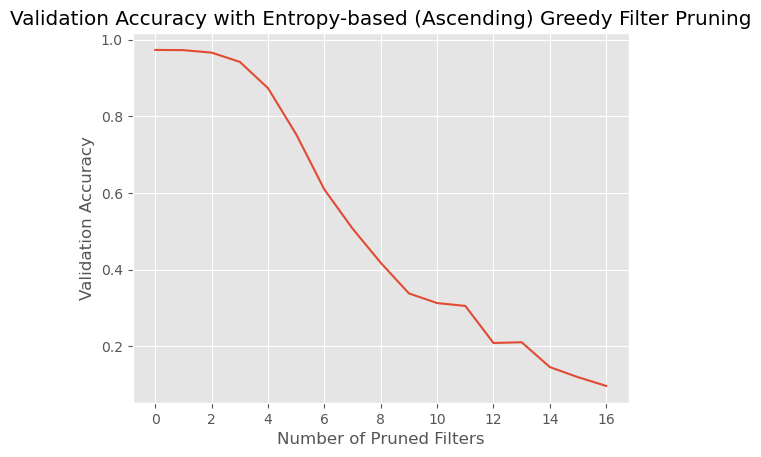

In [ ]:
# prune filters from lowest entropy to highest

pruned_accuracies_entropy_ascending = []

for i in range(17):
    # find the filter numbers of i filters with lowest entropy
    removed_filters = sorted_entropy_indices[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_entropy_ascending.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_entropy_ascending)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Entropy-based (Ascending) Greedy Filter Pruning')


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [12]
Validation accuracy: 0.9509333372116089

Removed filters: [2, 12]
Validation accuracy: 0.8937333226203918

Removed filters: [11, 2, 12]
Validation accuracy: 0.8694666624069214

Removed filters: [9, 11, 2, 12]
Validation accuracy: 0.8205999732017517

Removed filters: [15, 9, 11, 2, 12]
Validation accuracy: 0.5212000012397766

Removed filters: [4, 15, 9, 11, 2, 12]
Validation accuracy: 0.49533334374427795

Removed filters: [5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.4573333263397217

Removed filters: [13, 5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.3505333364009857

Removed filters: [0, 13, 5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.2718000113964081

Removed filters: [6, 0, 13, 5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.20106667280197144

Removed filters: [8, 6, 0, 13, 5, 4, 15, 9, 11, 2, 12]
Validation accuracy: 0.1451999992132187

Removed filters: [1, 8, 6, 0, 13, 5, 4, 15, 9, 11, 2, 12]


Text(0.5, 1.0, 'Validation Accuracy with Entropy-based (Descending) Greedy Filter Pruning')

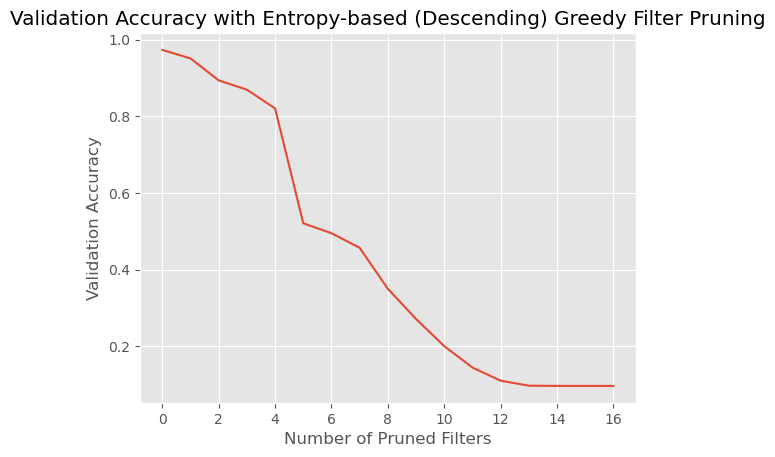

In [ ]:
# prune filters from highest entropy to lowest

pruned_accuracies_entropy_descending = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = sorted_entropy_indices[16-i:]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_entropy_descending.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_entropy_descending)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Entropy-based (Descending) Greedy Filter Pruning')

### Pruning mid-range entropies first (this is not interesting)


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [13]
Validation accuracy: 0.9525333046913147

Removed filters: [13, 0]
Validation accuracy: 0.9069333076477051

Removed filters: [13, 0, 5]
Validation accuracy: 0.885533332824707

Removed filters: [13, 0, 5, 6]
Validation accuracy: 0.7603333592414856

Removed filters: [13, 0, 5, 6, 4]
Validation accuracy: 0.7562666535377502

Removed filters: [13, 0, 5, 6, 4, 8]
Validation accuracy: 0.6240000128746033

Removed filters: [13, 0, 5, 6, 4, 8, 15]
Validation accuracy: 0.281333327293396

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1]
Validation accuracy: 0.2707333266735077

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1, 9]
Validation accuracy: 0.30686667561531067

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1, 9, 7]
Validation accuracy: 0.25546666979789734

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1, 9, 7, 11]
Validation accuracy: 0.17393332719802856

Removed filters: [13, 0, 5, 6, 4, 8, 15, 1, 9, 7, 11, 14]
Validation accu

Text(0.5, 1.0, 'Validation Accuracy with Mid-Entropy Filter Pruning')

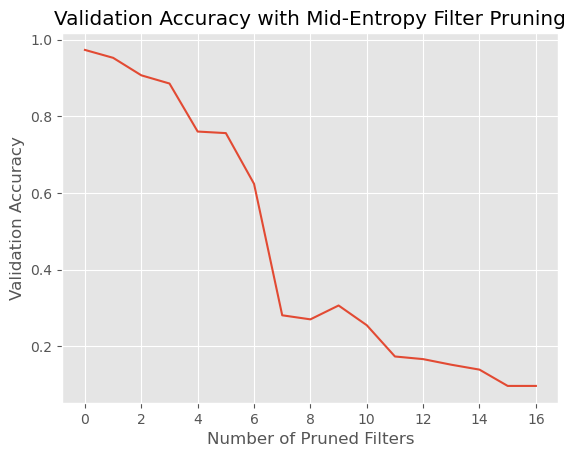

In [ ]:
middle_entropies = [13, 0, 5, 6, 4, 8, 15, 1, 9, 7, 11, 14, 2, 10, 12]

# prune mid-entropy filters
pruned_accuracies_entropy_mid = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = middle_entropies[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_entropy_mid.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_entropy_mid)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Mid-Entropy Filter Pruning')

### Plots for Entropy-Based Pruning

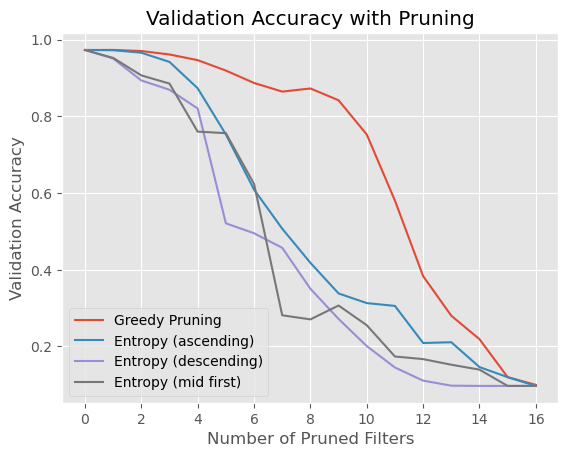

In [ ]:
# Comparing to the brute-force greedy pruning is not really fair... DO NOT USE?

plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies, label = 'Greedy Pruning')
#plt.plot(pruned_accuracies_reg, label = 'Dropout')
plt.plot(pruned_accuracies_entropy_ascending, label = 'Entropy (ascending)')
plt.plot(pruned_accuracies_entropy_descending, label = 'Entropy (descending)')
plt.plot(pruned_accuracies_entropy_mid, label = 'Entropy (mid first)')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Pruning')

plt.legend()

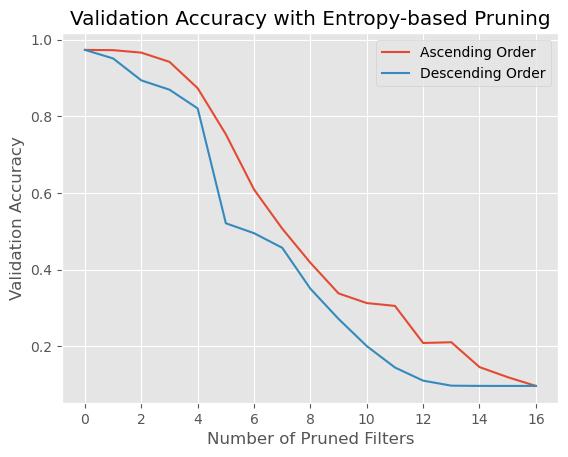

In [ ]:
# GOOD EXAMPLE HERE -- REMOVING HIGH-ENTROPY FILTERS REDUCES ACCURACY MUCH FASTER
# THAN REMOVING LOW-ENTROPY FILTERS

plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies_entropy_ascending, label = 'Ascending Order')
plt.plot(pruned_accuracies_entropy_descending, label = 'Descending Order')
#plt.plot(pruned_accuracies_entropy_mid, label = 'Middle-out Order')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Entropy-based Pruning')

plt.legend()

## MI-based Pruning

In [ ]:
import pickle as pkl
file = 'MI_matrices.pkl'
MI_matrices = pkl.load(open(file, 'rb'))

means = []

for k in range(16):
    for l in range(k):
        MI_matrix = MI_matrices[k+l]
        mean_MI = MI_matrix.mean(axis=0).reshape([26, 26])
        means.append([k, l, np.mean(mean_MI)])
        
means = np.array(means)

In [ ]:
#means[means[:, -1].argsort()][::-1]
MMMIs = np.zeros([16,2])

for k in range(16):
    MMMIs[k,0] = k
    for r in means:
        if k in r: MMMIs[k,1] += r[-1]
            
sorted_MMMIs = MMMIs[MMMIs[:, -1].argsort()]

sorted_MMMIs

array([[15.        ,  1.75847038],
       [13.        ,  1.77653241],
       [14.        ,  1.77763557],
       [12.        ,  1.79129674],
       [10.        ,  1.80656564],
       [11.        ,  1.81169735],
       [ 8.        ,  1.81546636],
       [ 9.        ,  1.81825458],
       [ 1.        ,  1.83294349],
       [ 3.        ,  1.83422645],
       [ 0.        ,  1.83704646],
       [ 7.        ,  1.83804175],
       [ 2.        ,  1.84049638],
       [ 6.        ,  1.84525981],
       [ 4.        ,  1.84830462],
       [ 5.        ,  1.84999787]])


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [15]
Validation accuracy: 0.8381999731063843

Removed filters: [15, 13]
Validation accuracy: 0.631600022315979

Removed filters: [15, 13, 14]
Validation accuracy: 0.5569333434104919

Removed filters: [15, 13, 14, 12]
Validation accuracy: 0.4334000051021576

Removed filters: [15, 13, 14, 12, 10]
Validation accuracy: 0.3779333233833313

Removed filters: [15, 13, 14, 12, 10, 11]
Validation accuracy: 0.37380000948905945

Removed filters: [15, 13, 14, 12, 10, 11, 8]
Validation accuracy: 0.29899999499320984

Removed filters: [15, 13, 14, 12, 10, 11, 8, 9]
Validation accuracy: 0.3494666814804077

Removed filters: [15, 13, 14, 12, 10, 11, 8, 9, 1]
Validation accuracy: 0.2662000060081482

Removed filters: [15, 13, 14, 12, 10, 11, 8, 9, 1, 3]
Validation accuracy: 0.21160000562667847

Removed filters: [15, 13, 14, 12, 10, 11, 8, 9, 1, 3, 0]
Validation accuracy: 0.15066666901111603

Removed filters: [15, 13, 14, 12, 10,

Text(0.5, 1.0, 'Validation Accuracy with Ascending Mean MMI')

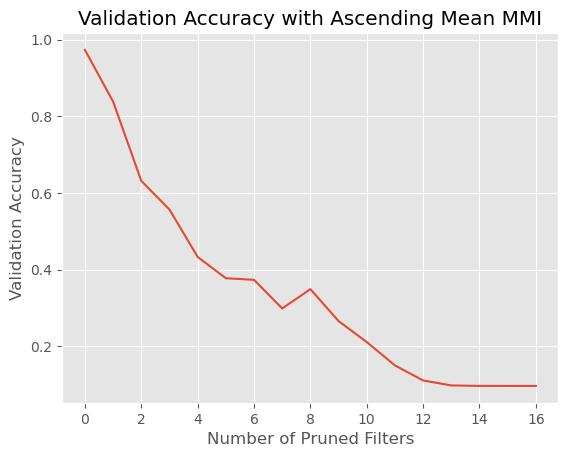

In [ ]:
prune_index_MMMI_ascending = [int(x) for x in sorted_MMMIs[:,0]]

# prune low MMMI filters
pruned_accuracies_MI_asc = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = prune_index_MMMI_ascending[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_MI_asc.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_MI_asc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Ascending Mean MMI')


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [5]
Validation accuracy: 0.9720666408538818

Removed filters: [5, 4]
Validation accuracy: 0.9669333100318909

Removed filters: [5, 4, 6]
Validation accuracy: 0.9621999859809875

Removed filters: [5, 4, 6, 2]
Validation accuracy: 0.9185333251953125

Removed filters: [5, 4, 6, 2, 7]
Validation accuracy: 0.8654666543006897

Removed filters: [5, 4, 6, 2, 7, 0]
Validation accuracy: 0.7079333066940308

Removed filters: [5, 4, 6, 2, 7, 0, 3]
Validation accuracy: 0.5705333352088928

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1]
Validation accuracy: 0.46086665987968445

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1, 9]
Validation accuracy: 0.6223999857902527

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1, 9, 8]
Validation accuracy: 0.4203333258628845

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1, 9, 8, 11]
Validation accuracy: 0.382999986410141

Removed filters: [5, 4, 6, 2, 7, 0, 3, 1, 9, 8, 11, 10]
Validation accuracy: 0.30480000376

Text(0.5, 1.0, 'Validation Accuracy with Descending Mean MMI')

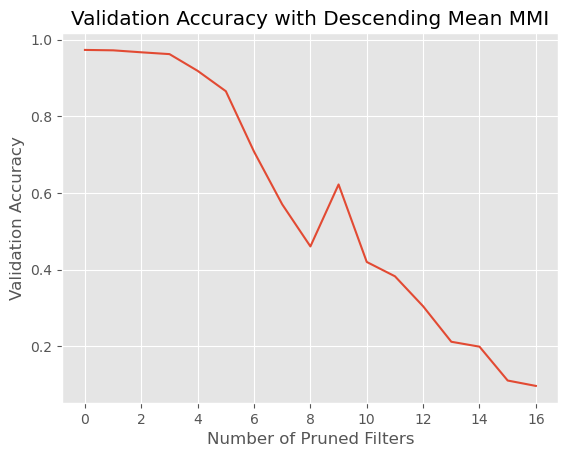

In [ ]:
prune_index_MMMI_descending = [int(x) for x in sorted_MMMIs[:,0][::-1]]

# prune low MMMI filters
pruned_accuracies_MI_desc = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = prune_index_MMMI_descending[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_MI_desc.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_MI_desc)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Descending Mean MMI')

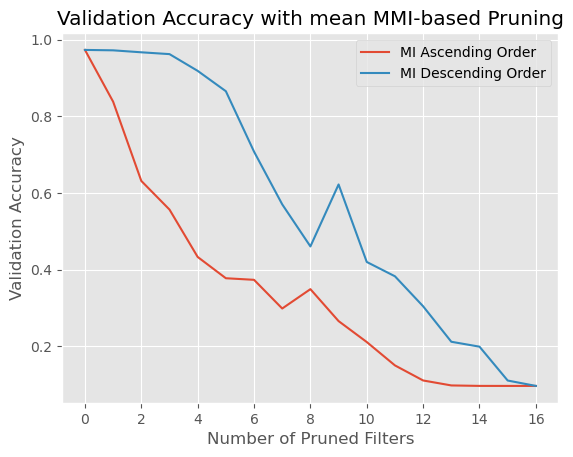

In [ ]:
# GOOD EXAMPLE HERE -- REMOVING LOW-MI FILTERS REDUCES ACCURACY MUCH FASTER
# THAN REMOVING HIGH-MI FILTERS

plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies_MI_asc, label = 'MI Ascending Order')
plt.plot(pruned_accuracies_MI_desc, label = 'MI Descending Order')

#plt.plot(pruned_accuracies, label = 'Brute Force Greedy Pruning')
#plt.plot(pruned_accuracies_entropy_mid, label = 'Middle-out Order')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with mean MMI-based Pruning')

plt.legend()

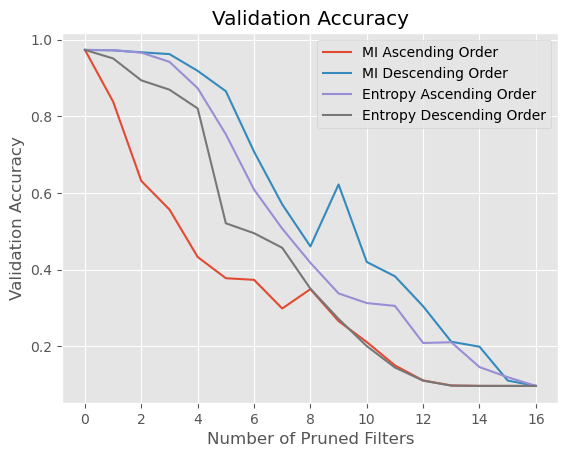

In [ ]:
# GOOD EXAMPLE HERE -- MI SEEMS MORE CONSEQUENTIAL THAN ENTROPY

plt.style.use('ggplot')
plt.figure()

plt.plot(pruned_accuracies_MI_asc, label = 'MI Ascending Order')
plt.plot(pruned_accuracies_MI_desc, label = 'MI Descending Order')
plt.plot(pruned_accuracies_entropy_ascending, label = 'Entropy Ascending Order')
plt.plot(pruned_accuracies_entropy_descending, label = 'Entropy Descending Order')

#plt.plot(pruned_accuracies, label = 'Brute Force Greedy Pruning')
#plt.plot(pruned_accuracies_entropy_mid, label = 'Middle-out Order')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy')

plt.legend()

In [ ]:
MI_pairs = np.zeros((16, 16))

for r in means:
    i = int(r[0])
    j = int(r[1])
    MI_pairs[i, j] = r[2]
    MI_pairs[j, i] = r[2]

MI_descending = []

for i in range(16):
    MI_sums = MI_pairs.sum(axis = 0)
    max_MI_index = np.argmax(MI_sums)
    
    MI_descending.append(max_MI_index)
    
    MI_pairs[:, max_MI_index] = 0
    MI_pairs[max_MI_index, :] = 0
    
MI_descending

[5, 4, 1, 2, 3, 7, 6, 0, 8, 9, 10, 11, 14, 13, 12, 0]


Removed filters: []
Validation accuracy: 0.9731333255767822

Removed filters: [5]
Validation accuracy: 0.9720666408538818

Removed filters: [5, 4]
Validation accuracy: 0.9669333100318909

Removed filters: [5, 4, 1]
Validation accuracy: 0.9608666896820068

Removed filters: [5, 4, 1, 2]
Validation accuracy: 0.916533350944519

Removed filters: [5, 4, 1, 2, 3]
Validation accuracy: 0.8675333261489868

Removed filters: [5, 4, 1, 2, 3, 7]
Validation accuracy: 0.7509333491325378

Removed filters: [5, 4, 1, 2, 3, 7, 6]
Validation accuracy: 0.5921333432197571

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0]
Validation accuracy: 0.46086665987968445

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0, 8]
Validation accuracy: 0.3790000081062317

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0, 8, 9]
Validation accuracy: 0.4203333258628845

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0, 8, 9, 10]
Validation accuracy: 0.3470666706562042

Removed filters: [5, 4, 1, 2, 3, 7, 6, 0, 8, 9, 10, 11]
Validation accuracy: 0.30480000376

Text(0.5, 1.0, 'Validation Accuracy with Descending Mean MMI (Proper)')

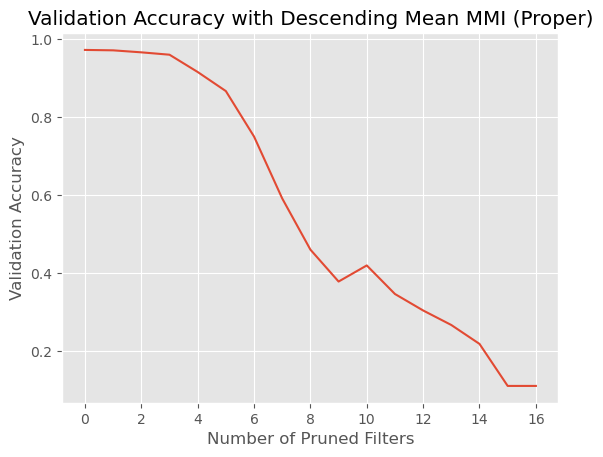

In [ ]:
# prune low MMMI filters
pruned_accuracies_MI_desc_proper = []

for i in range(17):
    # find the filter numbers of i filters with highest entropy
    removed_filters = MI_descending[:i]
    
    # load full model
    model = load_model('CNN_MNIST_baseline')
    
    # get the weights
    weights = model.get_weights()
    
    # set the removed filter and current filter weights and biases to 0
    weights[0][:, :, 0, removed_filters] *= 0
    weights[1][removed_filters] *= 0
    model.set_weights(weights)

    # compute validation accuracy after removing the current filter
    validation_accuracy = model.evaluate(validationX, validationY, verbose = 0)[-1]
    pruned_accuracies_MI_desc_proper.append(validation_accuracy)

    print('\nRemoved filters:', removed_filters)
    print('Validation accuracy:', validation_accuracy)
    
plt.style.use('ggplot')
plt.figure()
plt.plot(pruned_accuracies_MI_desc_proper)
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy with Descending Mean MMI (Proper)')

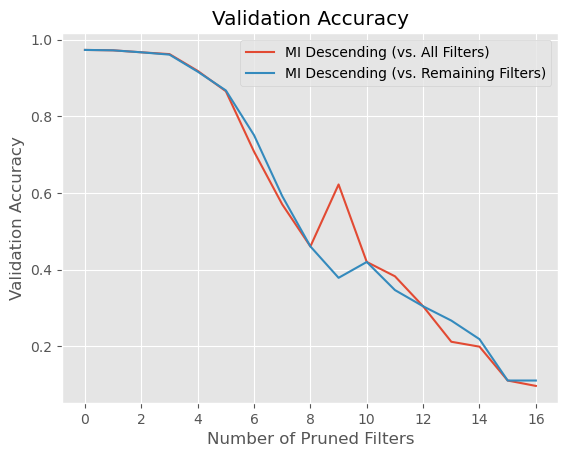

In [ ]:
# GOOD EXAMPLE HERE -- MI SEEMS MORE CONSEQUENTIAL THAN ENTROPY

plt.style.use('ggplot')
plt.figure()

#plt.plot(pruned_accuracies_MI_asc, label = 'MI Ascending Order')
plt.plot(pruned_accuracies_MI_desc, label = 'MI Descending (vs. All Filters)')
#plt.plot(pruned_accuracies_entropy_ascending, label = 'Entropy Ascending')
#plt.plot(pruned_accuracies_entropy_descending, label = 'Entropy Descending Order')
plt.plot(pruned_accuracies_MI_desc_proper, label = 'MI Descending (vs. Remaining Filters)')

#plt.plot(pruned_accuracies, label = 'Brute Force Greedy Pruning')
#plt.plot(pruned_accuracies_entropy_mid, label = 'Middle-out Order')

plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Pruned Filters')
plt.title('Validation Accuracy')

plt.legend()

In [ ]:
# Prune Based on 

## PCA of filter entropies

## (This code for entropies at different layers is not integrated with the code above yet)

In [ ]:
from scipy.special import entr

In [ ]:
# all layers
#indices = range(11)

# pooling and activations
indices = [1,2,4,5,6,8,10]

# activations only
#indices = [1, 4, 8, 10]

for l in range(7):
    # print the mean entropy of the data
    if l == -1:
        print('input data')
        entropy = entr(trainX).sum(axis = 0).mean()
        print('Mean input data entropy is', entropy)
        continue

    # print layer number and grab the activations from this layer
    else:
        print('\nlayer', l)
        print(model.layers[l])
        activation = activations[l]

    # scale values between 0 and 1 ONLY for conv and dense layers
    if l not in indices:
        # uncomment this "continue" if you want to skip pre-activation conv and dense layers
        #continue
        print('*** Performing min-max scaling for pre-activation conv or dense layer ***')
        max_act = np.amax(activation)
        min_act = np.amin(activation)
        activation = (activation - min_act) / (max_act - min_act)

    # compute entropy summed across axis images (axis 0)
    entropy = entr(activation).sum(axis = 0)

    # compute mean entropy of layer
    layer_entropy = entropy.mean()
    print('Mean layer output entropy is', layer_entropy)


layer 0
*** Performing min-max scaling for pre-activation conv or dense layer ***
Mean layer output entropy is 1265.2261

layer 1
Mean layer output entropy is -inf

layer 2
Mean layer output entropy is 11220.089

layer 3
*** Performing min-max scaling for pre-activation conv or dense layer ***
Mean layer output entropy is 11137.508

layer 4
Mean layer output entropy is 11137.747

layer 5
Mean layer output entropy is -inf

layer 6
Mean layer output entropy is 390.6034
